### Data Preprocessing and Splitting for Phytoplankton Biomass and Fluor-Probe Datasets

##### Introduction
This notebook provides a detailed explanation of the data preprocessing and splitting procedures used in the analysis of two distinct datasets: the phytoplankton biomass dataset and the fluor-probe dataset. These datasets were combined to facilitate the prediction of chlorophyll concentrations for four phytoplankton groups. The merging process involved multiple steps to ensure compatibility and to create train, validation, and test datasets for subsequent modeling.

##### Datasets Description
The two primary datasets used in this study are as follows:

1. **Phytoplankton Biomass Data**: This dataset contains measurements of phytoplankton biomass for different phytoplankton groups. The measurements were taken weekly at discrete depths over multiple years.

2. **Fluor-Probe Data**: This dataset consists of fluorescence measurements at continuous depths over multiple years, sampled weekly. Additionally, this dataset includes predictions of chlorophyll concentrations for four specific phytoplankton groups, which are a subset of the phytoplankton groups present in the biomass data.

### Step 1: Train-Validation-Test Split
In the first step, the datasets were split into three subsets: the training set, the validation set, and the test set. This splitting was done based on time periods as follows:

- **Training Set**: This set includes all data up until the year 2022 - not included.
    - n = 68538

- **Validation Set**: All data between January 2022 and February 2022.
     - n = 105

- **Test Set**: This set contains all data from March 2022 to June 2022.
    - n = 221

### Step 2: Merging Validation and Test Datasets
In the second step, the validation and test datasets were merged based on records from the fluor-probe data that had the closest depth measurements to the discrete depth measurements in the biomass data for a given week-year combination. This merging ensured that the fluorescence measurements and chlorophyll predictions were aligned with the corresponding phytoplankton biomass data for validation and testing purposes.

Let:
- $D_{\text{biomass}}$ represent the biomass dataset.
- $D_{\text{fp}}$ represent the fluor-probe dataset.
- $\text{WY}_i$ denote the i-th week-year combination.
- $D_{r_j}$ denote the j-th record at dataset ${D}$

For each $\text{WY}_i$ in $D_{\text{biomass}}$ and $D_{\text{fp}}$:
- Find the continuous depth measurement in $D_{\text{fp}}$ that minimizes the absolute difference between the discrete depth of $\text{WY}_i$ and the depths in $D_{\text{fp}}$. This can be expressed as:


$\
\
\
\
\
\
\
D_{r_j} = \text{argmin}_{\text{depth} \in D_{\text{fp}} \cap \text{WY}_i, \text{discrete_depth} \in D_{\text{biomass}} \cap \text{WY}_i} \left| \text{depth} - \text{discrete_depth} \right|
$


### Step 3: Merging Training Dataset
Finally, the training dataset was merged in a different manner. Each record in the training dataset with a discrete depth measurement was duplicated along with the continuous depth measurements for the corresponding week-year combination. This step is a preperation for the following step of biomass estimation along continous depths.

### Step 4: Biomass Estimation along Continuous Depth

In the fourth step of our data preprocessing pipeline, we perform biomass estimation along the continuous depth for a given week-year combination in the training dataset. This step is crucial for aligning the discrete and continuous depth measurements, allowing us to make more robust models.

The estimation is carried out by calculating the gradient of the biomass with respect to the discrete depth. This gradient essentially represents how biomass changes concerning discrete depth measurements. We use this gradient as a "step size" to estimate the biomass at an unknown continuous depth.

let's denote the discrete depth measurements as $D$ and the corresponding biomass measurements as $B$.
Assuming the records are sorted in ascending order with respect to the discrete depth, the gradient of record ${i}$ is calculated as:

$
\nabla{B_i} = \frac{\partial{B_i}}{\partial{D_i}} = \frac{B_i - B_{i-1}}{D_i - D_{i-1}}
$

If $B_{i-1}$ and $D_{i-1}$ does not exists, we set them to zero.

This gradient reflects the rate of change of biomass concerning discrete depth.

Once we have the gradient, we can utilize it to estimate the biomass at an unknown continuous depth, denoted as $D_c$. This estimation is performed as follows:

$
B_c = B_{i} + \nabla{B_i} \cdot (D_c - D_{i})
$

Where $B_c$ is the estimated biomass at the continuous depth $D_c$.

By applying this estimation process for each continuous depth measurement, we bridge the gap between discrete and continuous depth data, creating a continuous profile of biomass for the given week-year combination in the training dataset.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from data_utils import *
from eda_utils import *
from train_utils import *
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
import pickle
import os

import warnings
# Ignore warnings
warnings.filterwarnings("ignore")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
figure_titles = {
    'red': '700 nm',
    'green': '525 nm',
    'yellow': '570 nm',
    'orange': '610 nm',
    'violet': '370 nm',
    'brown': '590 nm',
    'blue': '470 nm',
    'pressure': 'Depth (m)',
    'temp_sample': 'Temperature',
    'Total conc': 'Total Chl concentration',
    '2' : 'Cyanophyta (Blue-green)',
    '3' : 'Chrysophyta (Diatoms)',
    '4' : 'Chlorophyta (Green-algea)',
    '5' : 'Dinophyte (Dinoflagellate)',
    '6' : 'Cryptophyta',
    'month': 'Month'
}

# Data Preprocessing

## Dataset creation

In [4]:
phyt_cod_path = 'data/PHYT_COD_ForDvirLafer.csv'
phyto_path = 'data/Phyto4DvirLafer.csv'

biomass_by_week_year_group = get_biomass_data(phyt_cod_path, phyto_path)

In [5]:
fp_path = 'data/FP_2017_ForDvirLafer.csv'

fp_df = get_fluorprobe_data(fp_path)

## Splitting to test temporarily & Extracting probe's test data

In [6]:
biomass_test = biomass_by_week_year_group[(biomass_by_week_year_group['year'] == 2022) & (biomass_by_week_year_group['month'] >= 3)]
biomass_val = biomass_by_week_year_group[(biomass_by_week_year_group['year'] == 2022) & (biomass_by_week_year_group['month'] < 3)]
biomass_train = biomass_by_week_year_group[(~biomass_by_week_year_group.index.isin(biomass_test.index)) & (~biomass_by_week_year_group.index.isin(biomass_val.index))]

fp_test = fp_df[(fp_df['year'] == 2022) & (fp_df['month'] >= 3)]
fp_val = fp_df[(fp_df['year'] == 2022) & (fp_df['month'] < 3)]
fp_train = fp_df[(~fp_df.index.isin(fp_test.index)) & (~fp_df.index.isin(fp_val.index))]

merged_train = merge_fp_biomass_df(fp_train, biomass_train, is_train=True) # Merging fully
merged_val = merge_fp_biomass_df(fp_val, biomass_val, is_train=False) # Merging fully
merged_test = merge_fp_biomass_df(fp_test, biomass_test, is_train=False) # Merging only closest records by depth

In [7]:
merged_train = merged_train.drop(['Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta'], axis=1).reset_index(drop=True)

fluor_groups_map = {
    2: 'Bluegreen',
    3: 'Diatoms',
    4: 'Green Algae',
    6: 'Cryptophyta'
}

fluor_val_df = merged_val[['group_num', 'month', 'week', 'year', 'Depth', 'sum_biomass_ug_ml', 'Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta']].reset_index(drop=True)
merged_val = merged_val.drop(['Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta'], axis=1).reset_index(drop=True)

fluor_test_df = merged_test[['group_num', 'month', 'week', 'year', 'Depth', 'sum_biomass_ug_ml', 'Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta']].reset_index(drop=True)
merged_test = merged_test.drop(['Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta'], axis=1).reset_index(drop=True)

In [8]:
len(merged_train.sum_biomass_ug_ml.unique())

2043

In [9]:
biomass_estimation(merged_train)

In [10]:
len(merged_train.sum_biomass_ug_ml.unique())

55357

### Saving original train df for later tests

In [11]:
orig_merged_train = merged_train.copy()

In [12]:
orig_merged_train.loc[orig_merged_train['Depth'] >= 21, 'Depth'] = 21

In [13]:
print(len(merged_train))
print(len(merged_val))
print(len(merged_test))

55389
79
174


## Motivation

## Exploring Correlations Between Fluor-Probe Predictions and Phytoplankton Biomass at Kinneret Lake


### Introduction

Phytoplankton play a crucial role in aquatic ecosystems, serving as primary producers and influencing the overall health and nutrient dynamics of aquatic environments. Monitoring phytoplankton biomass is essential for understanding and managing these ecosystems. One commonly used method for estimating phytoplankton biomass is the use of fluorometric probes, which provide predictions of chlorophyll concentrations for specific phytoplankton groups. However, these predictions often cover only a limited number of phytoplankton groups. In this research, we seek to expand our understanding by exploring correlations between fluor-probe predictions and the biomass of additional phytoplankton groups at Kinneret Lake.

### Motivation

Our research is motivated by several key factors:

#### Limited Coverage of Phytoplankton Groups

The fluor-probe's predictions typically include only a subset of phytoplankton groups. However, Kinneret Lake is known to support a diverse range of phytoplankton species, including 'Bluegreen', 'Diatoms', 'Green Algae', and 'Cryptophyta', among others. To gain a more comprehensive understanding of the lake's phytoplankton dynamics, it is essential to explore the biomass of these additional groups beyond the scope of the fluor-probe's predictions.

#### Predicted Chlorophyll vs. Biomass

While fluor-probe predictions offer insights into chlorophyll concentrations, they do not directly estimate the biomass of phytoplankton groups. Understanding the biomass of these groups is crucial for assessing their ecological significance and potential impacts on the lake's ecosystem. By examining correlations, we can investigate the extent to which the fluor-probe's predictions reflect variations in actual phytoplankton biomass.

#### Temporal and Depth-Based Correlations

To gain a comprehensive perspective, we plan to assess correlations between fluor-probe predictions and phytoplankton biomass along two key axes:

##### Monthly Correlation

We will investigate how the correlations between fluor-probe predictions and phytoplankton biomass vary on a monthly basis. Seasonal changes and environmental factors can influence phytoplankton dynamics, and understanding these variations is essential for effective monitoring and management.

##### Depth-Based Correlation

Phytoplankton distribution within the water column can vary significantly. By examining correlations based on discrete depth levels, we aim to uncover potential depth-related patterns in the relationship between fluor-probe predictions and phytoplankton biomass. This information can be valuable for understanding vertical phytoplankton distributions within the lake.

### Methodology

To explore the correlations between fluor-probe predictions and phytoplankton biomass, we will collect data on both chlorophyll predictions from the fluor-probe and phytoplankton biomass for the 'Bluegreen', 'Diatoms', 'Green Algae', and 'Cryptophyta' groups. The data collection will be conducted monthly and at multiple discrete depth levels within Kinneret Lake.

We will use statistical techniques to quantify the strength and direction of these correlations. Specifically, we will calculate correlation coefficients, such as Pearson's correlation coefficient, to assess the linear relationships between the two variables. Additionally, we may employ other statistical methods, including regression analysis, to explore potential predictive models.

### Conclusion

Our research aims to enhance our understanding of phytoplankton dynamics in Kinneret Lake by bridging the gap between fluor-probe predictions and actual biomass measurements for multiple phytoplankton groups. By examining correlations across different temporal and depth dimensions, we hope to reveal valuable insights into the ecological relationships within the lake's phytoplankton community. This knowledge can contribute to more effective monitoring and management of this important aquatic ecosystem.

<div style="height: 200px;"></div>


In [14]:
fluor_train_df = merge_fp_biomass_df(fp_train.drop('Depth', axis=1), biomass_train, is_train=False)
fluor_train_df = fluor_train_df[['group_num', 'month', 'week', 'year', 'Depth', 'sum_biomass_ug_ml', 'Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta']].reset_index(drop=True)

In [15]:
fluor_train_df.loc[fluor_train_df['Depth'] >= 21, 'Depth'] = 21

In [16]:
# Use Times New Roman or Arial font and adjust font sizes
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

# Define a limited and distinguishable color palette
color_palette = sns.color_palette("coolwarm", as_cmap=True)

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def corr_fp_biomass_by_depth(df):
    # Create a DataFrame containing only the relevant columns
    relevant_columns = ['Depth', 'group_num', 'sum_biomass_ug_ml'] + [fluor_groups_map[group_num] for group_num in fluor_groups_map.keys()]
    df_relevant = df[relevant_columns]
    df_relevant.rename(columns={x: figure_titles[str(x)] for x in fluor_groups_map.keys()}, inplace=True)

    # Initialize an empty dictionary to store correlation results
    correlation_results = {}

    # Loop through each group and calculate the correlation for each depth
    for group_num, column_name in fluor_groups_map.items():
        # Filter the DataFrame for the current group
        group_df = df_relevant[df_relevant['group_num'] == group_num]

        # Initialize a dictionary to store correlation results for the current group
        group_correlations = {}

        # Group the data by 'depth'
        grouped_by_depth = group_df.groupby('Depth')

        # Calculate and store correlation for each depth
        for depth, group_data in grouped_by_depth:
            correlation = group_data[['sum_biomass_ug_ml', column_name]].corr().iloc[0, 1]
            group_correlations[depth] = correlation

        # Store the correlation results for the current group
        correlation_results[column_name] = group_correlations
    
    correlation_results["Cyanophyta (Blue-green)"] = correlation_results.pop('Bluegreen')
    correlation_results["Chrysophyta (Diatoms)"] = correlation_results.pop('Diatoms')
    correlation_results["Chlorophyta (Green-algea)"] = correlation_results.pop('Green Algae')

#     0-3, 3-5, 5-10, 10-15, 15-20, and 20-43
    for group_name in correlation_results.keys():
        correlation_results[group_name]['0-3'] = correlation_results[group_name].pop(3)
        correlation_results[group_name]['3-5'] = correlation_results[group_name].pop(5)
        correlation_results[group_name]['5-10'] = correlation_results[group_name].pop(10)
        correlation_results[group_name]['10-15'] = correlation_results[group_name].pop(15)
        correlation_results[group_name]['15-20'] = correlation_results[group_name].pop(20)
        correlation_results[group_name]['20-43'] = correlation_results[group_name].pop(21)
    
    # Optionally, you can visualize the results in a heatmap
    plt.figure(figsize=(5, 4), dpi=300)  # Adjust the figure size and dpi
    sns.heatmap(pd.DataFrame(correlation_results), annot=True, cmap=color_palette, fmt=".2f", vmin=-1, vmax=1)

    plt.ylabel('Depth', fontsize=12)
#     plt.xlabel('Taxonomic Groups', fontsize=12)
    plt.show()


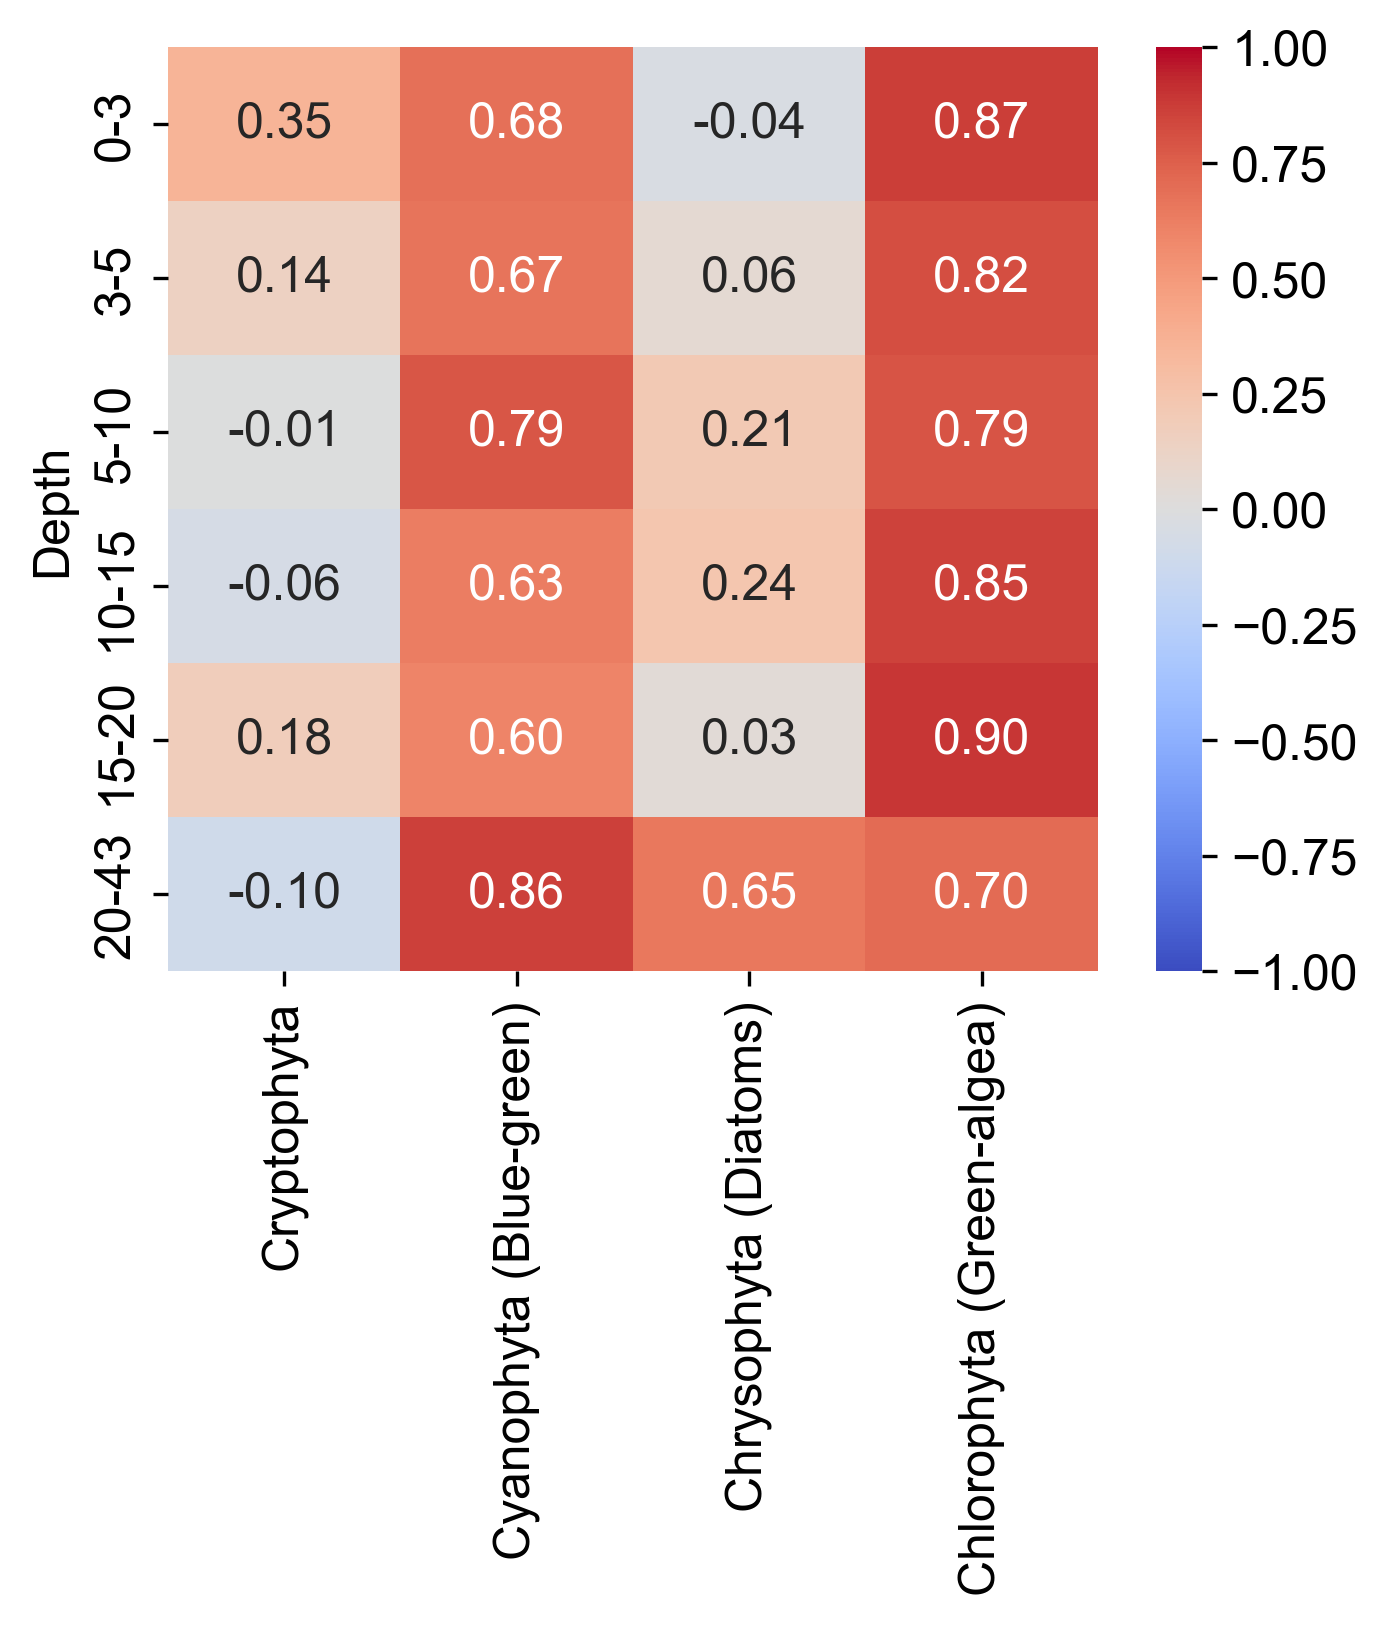

In [18]:
# Correlation Matrix for Different Groups per depth
corr_fp_biomass_by_depth(fluor_train_df)

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def corr_fp_biomass_by_month(df):
    # Create a DataFrame containing only the relevant columns
    relevant_columns = ['month', 'group_num', 'sum_biomass_ug_ml'] + [fluor_groups_map[group_num] for group_num in fluor_groups_map.keys()]
    df_relevant = df[relevant_columns]

    # Initialize an empty dictionary to store correlation results
    correlation_results = {}

    # Loop through each group and calculate the correlation for each month
    for group_num, column_name in fluor_groups_map.items():
        # Filter the DataFrame for the current group
        group_df = df_relevant[df_relevant['group_num'] == group_num]

        # Initialize a dictionary to store correlation results for the current group
        group_correlations = {}

        # Group the data by 'month'
        grouped_by_month = group_df.groupby('month')

        # Calculate and store correlation for each month
        for month, group_data in grouped_by_month:
            correlation = group_data[['sum_biomass_ug_ml', column_name]].corr().iloc[0, 1]
            group_correlations[month] = correlation

        # Store the correlation results for the current group
        correlation_results[column_name] = group_correlations


    correlation_results["Cyanophyta (Blue-green)"] = correlation_results.pop('Bluegreen')
    correlation_results["Chrysophyta (Diatoms)"] = correlation_results.pop('Diatoms')
    correlation_results["Chlorophyta (Green-algea)"] = correlation_results.pop('Green Algae')

    # Optionally, you can visualize the results in a heatmap
    plt.figure(figsize=(5, 4), dpi=300)  # Adjust the figure size and dpi
    sns.heatmap(pd.DataFrame(correlation_results), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.ylabel('Month', fontsize=12)
#     plt.xlabel('Taxonomic Groups', fontsize=12)
    plt.show()


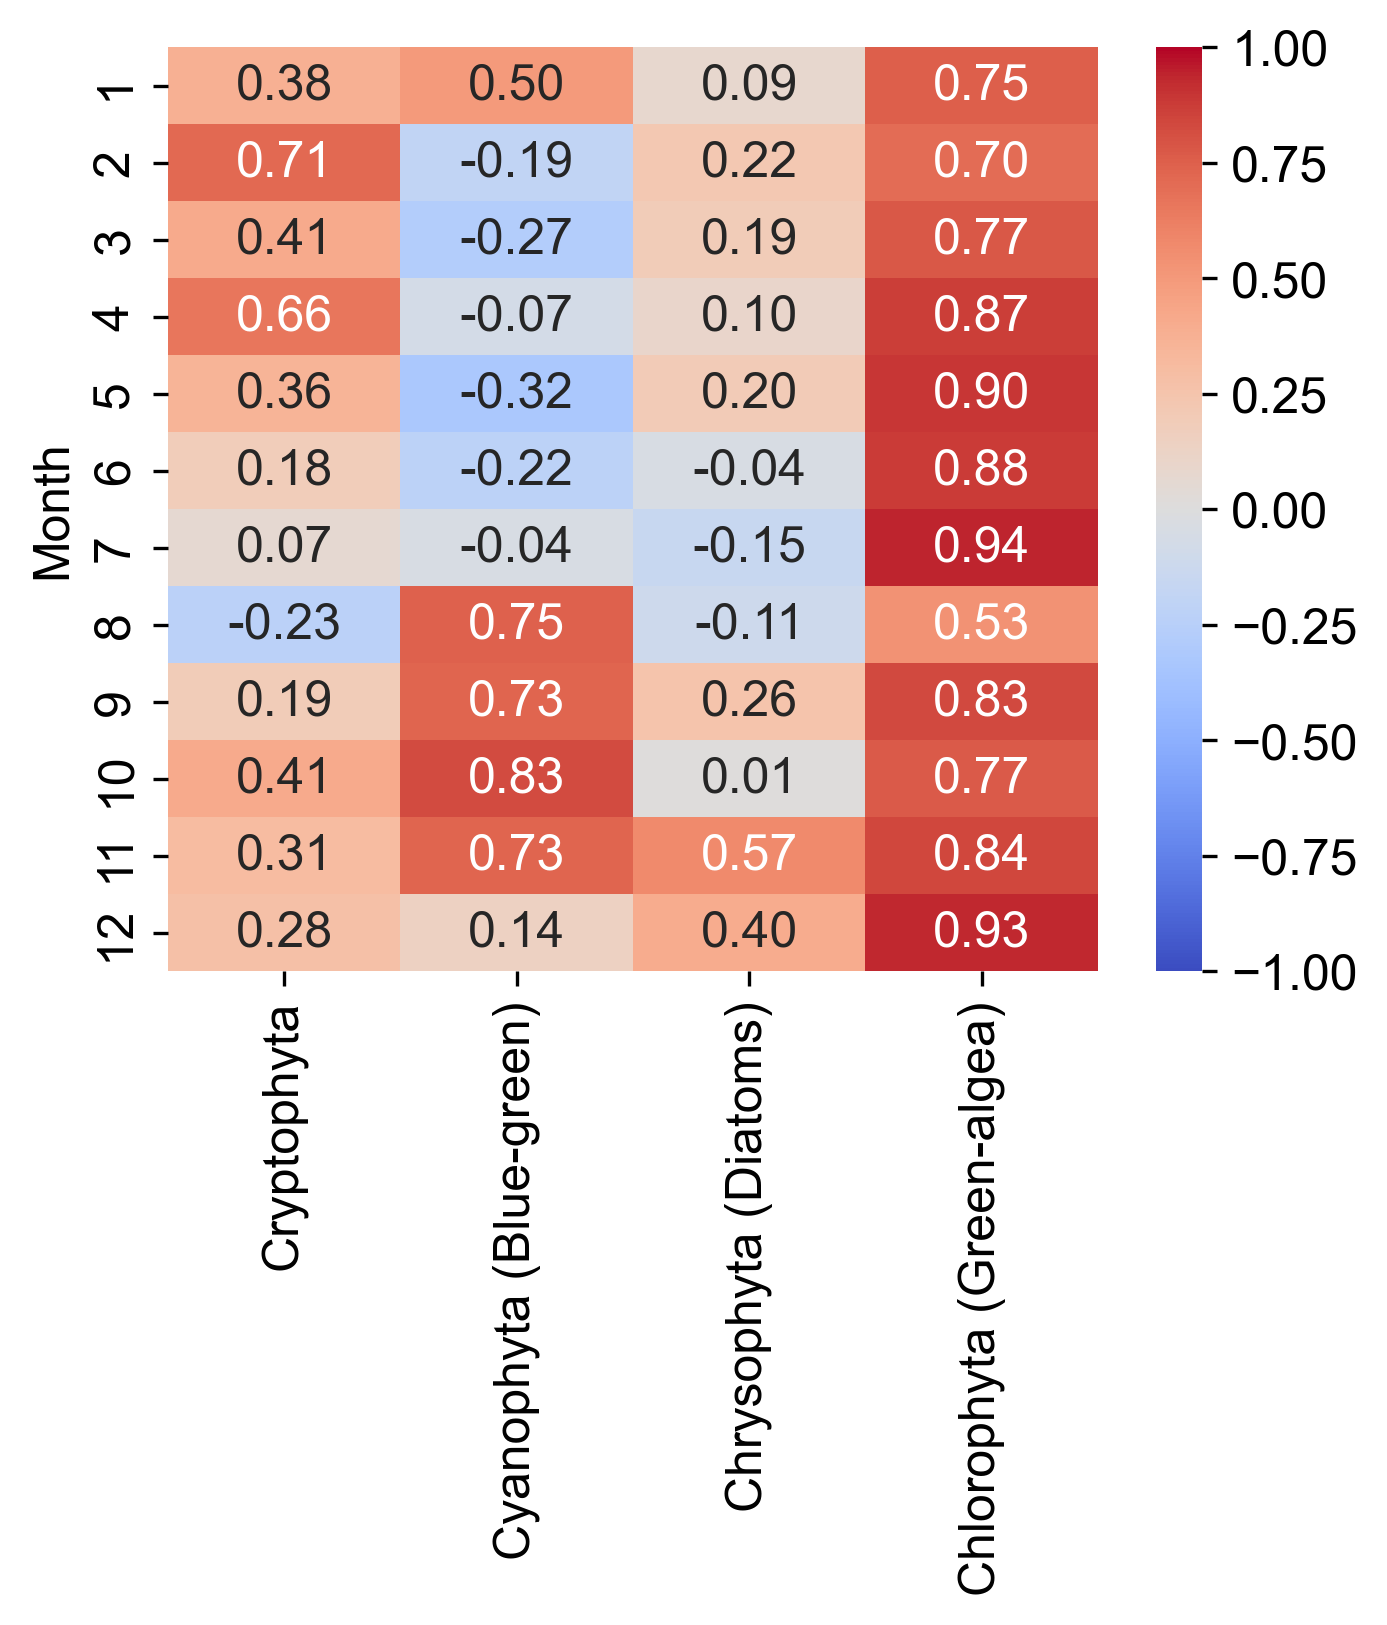

In [20]:
# Correlation Matrix for Different Groups per month
corr_fp_biomass_by_month(fluor_train_df)

### Exploratory Data Analysis (EDA) and Data Cleaning Processes

The goal of the analysis is to prepare the data for further modeling by addressing issues such as negative biomass values, outliers in signal values, and the need for data transformation and balancing.

1. **Removing Records with Negative Biomass**

   To ensure the integrity of the dataset, records with negative biomass values were removed. Mathematically, this process can be expressed as follows:
   
   Let $D$ represent the dataset, and $D'$ be the cleaned dataset. Then, we removed records $r$ from $D$ where $r_{\text{biomass}} < 0$, resulting in $D'$.

2. **Treating Discrete Depths**

   Due to a low number of records with discrete depths greater than or equal to 25, we made the decision to treat all records with discrete depths greater than or equal to 21 as having a discrete depth of 21. This decision was made to simplify the analysis while minimizing information loss:
   
   $
   \text{For } d \geq 21, \text{ set } d = 21.
   $

In [21]:
merged_train = merged_train[merged_train['sum_biomass_ug_ml'] >= 0]

In [22]:
merged_train.loc[merged_train['Depth'] >= 21, 'Depth'] = 21
merged_val.loc[merged_val['Depth'] >= 21, 'Depth'] = 21
merged_test.loc[merged_test['Depth'] >= 21, 'Depth'] = 21

In [23]:
signals = ['red', 'green', 'yellow', 'orange', 'violet', 'brown', 'blue', 'pressure', 'temp_sample', 'yellow_sub', 'sum_biomass_ug_ml']

3. **Visualizing Fluor-Probe Signals Using Boxplots**

   We visualized each of the fluor-probe signals using boxplots. The signals of interest include: red, green, yellow, orange, violet, brown, blue, pressure, temp_sample, yellow_sub, and sum_biomass_ug_ml. Boxplots provide a clear summary of the distribution of these signals.


4. **Removing Records with Outlier Signal Values**

   Outliers in signal values were identified and removed based on predefined boundaries for each signal. The boundaries are represented as lower and upper bounds:

   $
   \text{For each signal } S, \text{ remove records where } S < \text{lower bound} \text{ or } S > \text{upper bound}.
   $

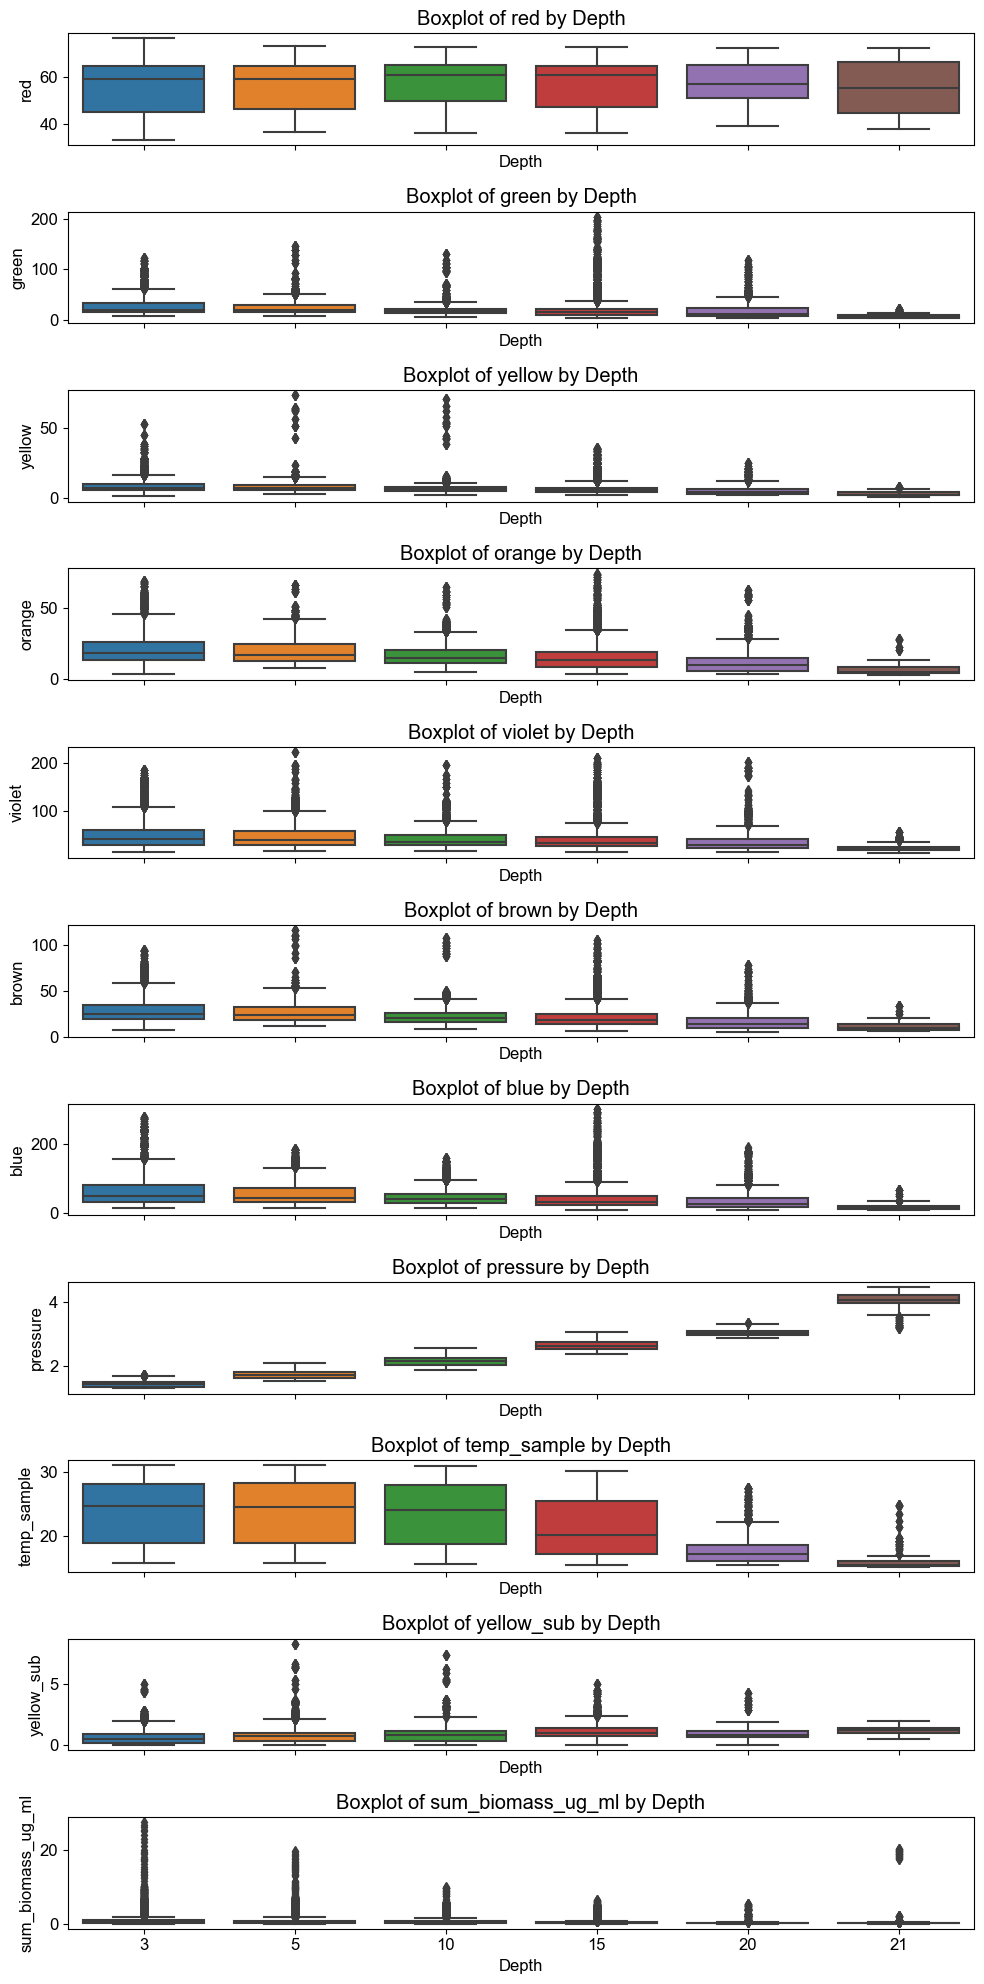

In [24]:
boxplot_by_depth(merged_train, signals, by_col='Depth')

In [25]:
signals.remove('sum_biomass_ug_ml')
signals.remove('pressure')
signals.remove('temp_sample')
boundaries = {
    'red': {'lower_bound': 0, 'upper_bound': 120},
    'green': {'lower_bound': 0, 'upper_bound': 100},
    'yellow': {'lower_bound': 0, 'upper_bound': 40},
    'orange': {'lower_bound': 0, 'upper_bound': 60},
    'violet': {'lower_bound': 0, 'upper_bound': 150},
    'brown': {'lower_bound': 0, 'upper_bound': 80},
    'blue': {'lower_bound': 0, 'upper_bound': 220},
    'yellow_sub': {'lower_bound': 0, 'upper_bound': 7}
}

filter_signals_by_boundaries(merged_train, signals, boundaries)

In [26]:
merged_train.shape

(52368, 18)

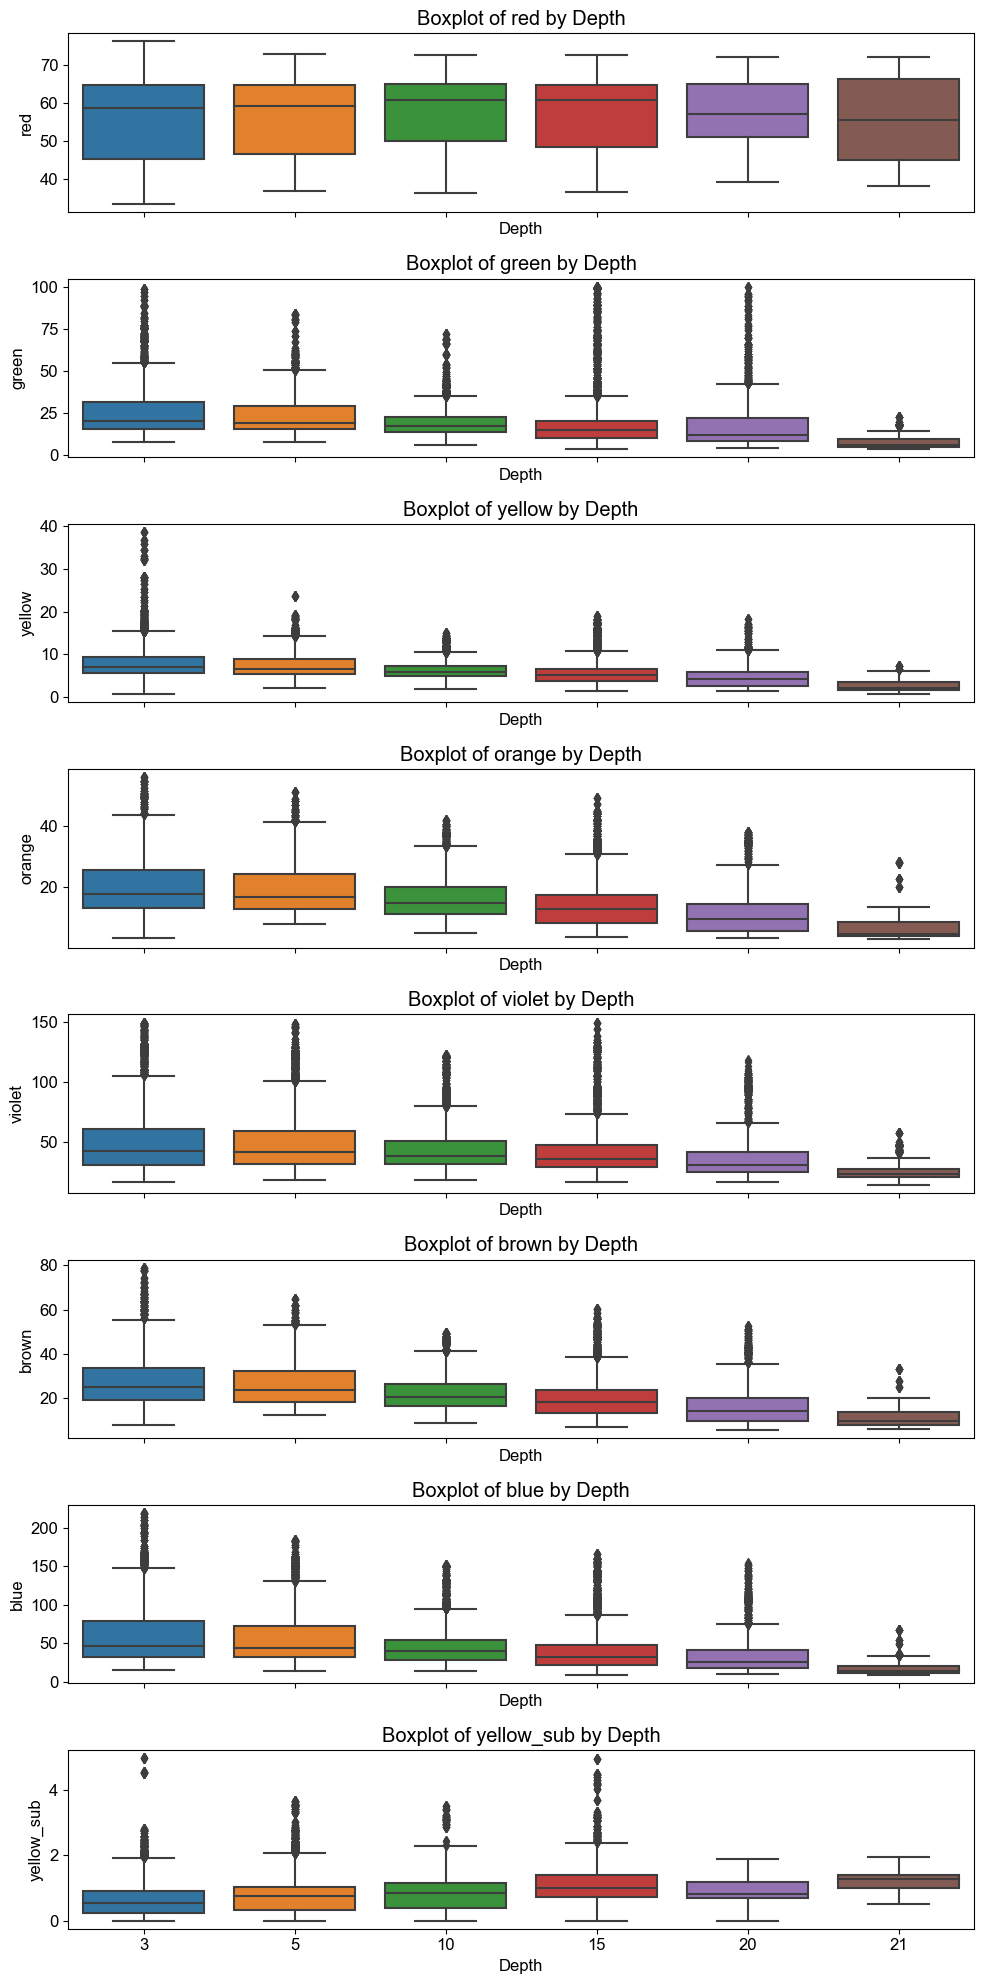

In [27]:
boxplot_by_depth(merged_train, signals, by_col='Depth')

In [28]:
custom_palette = {'Cyanophyta (Blue-green)': 'red', 'Chrysophyta (Diatoms)': 'orange', 'Chlorophyta (Green-algea)': 'purple',
                   'Dinophyte (Dinoflagellate)': 'green', 'Cryptophyta': 'blue'}

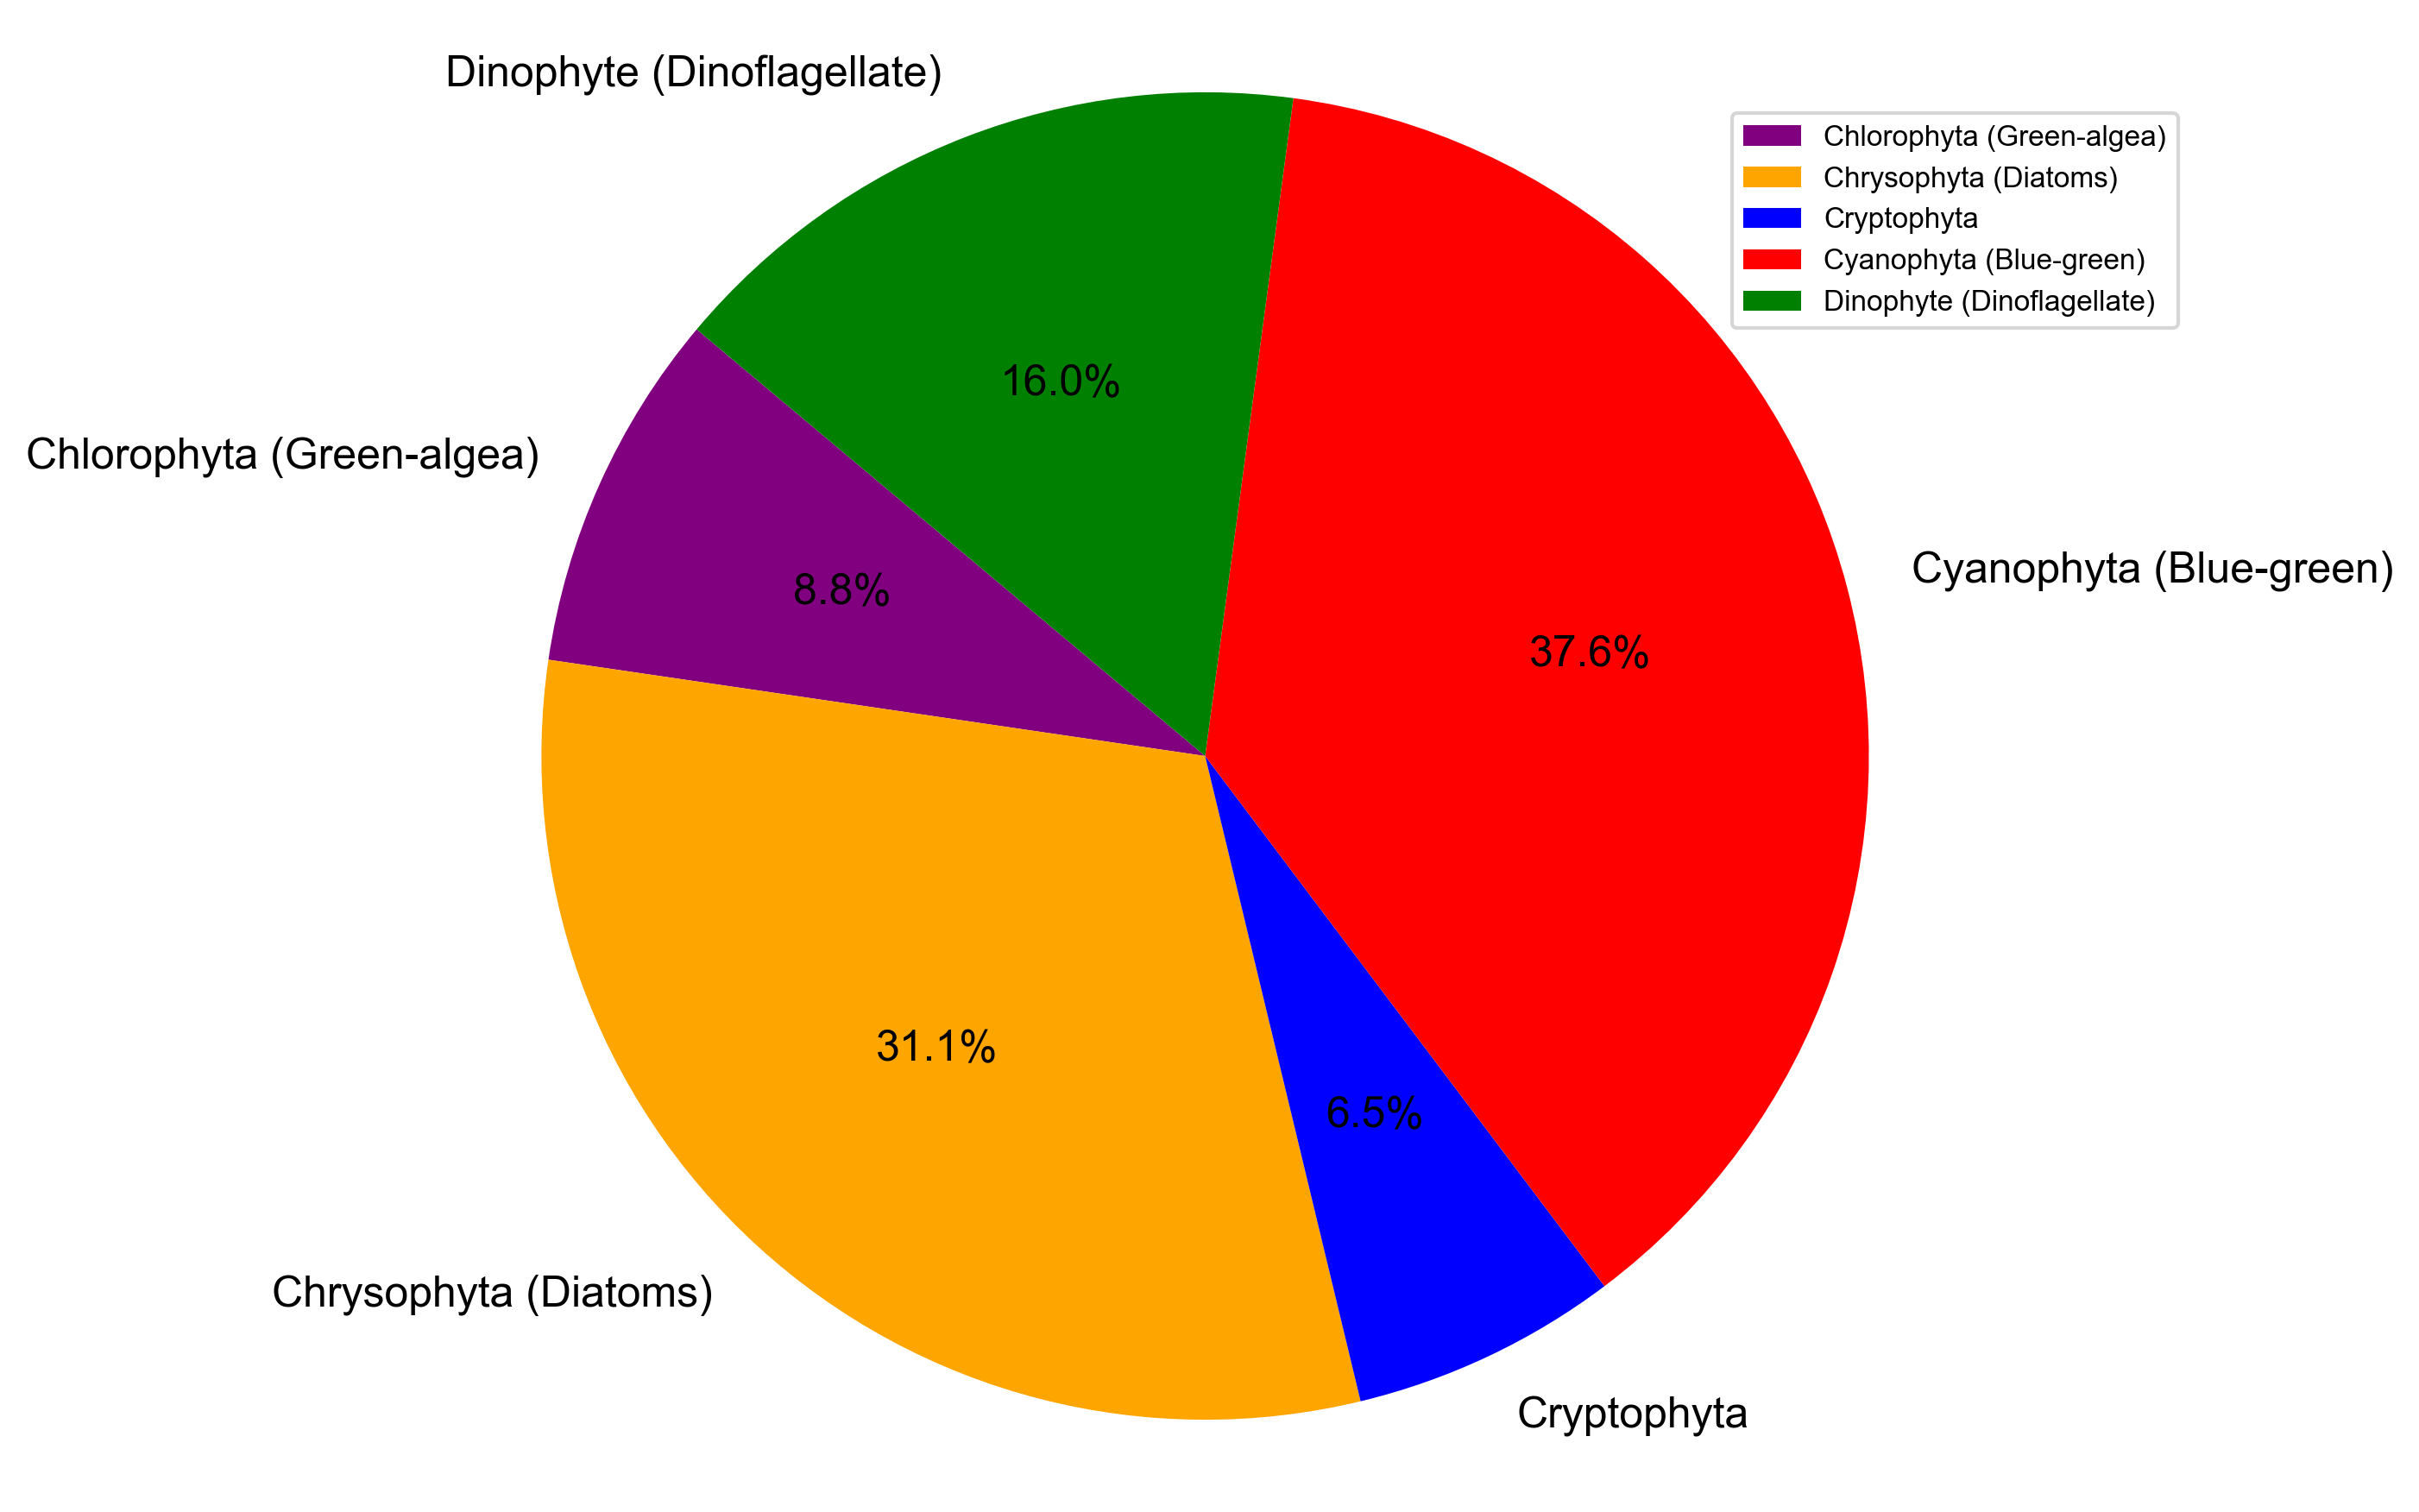

In [29]:
# merged_train['sum_biomass_ug_ml'] = merged_train['sum_biomass_ug_ml'].apply(np.exp)
groups_pie_chart(merged_train, figure_titles, custom_palette)

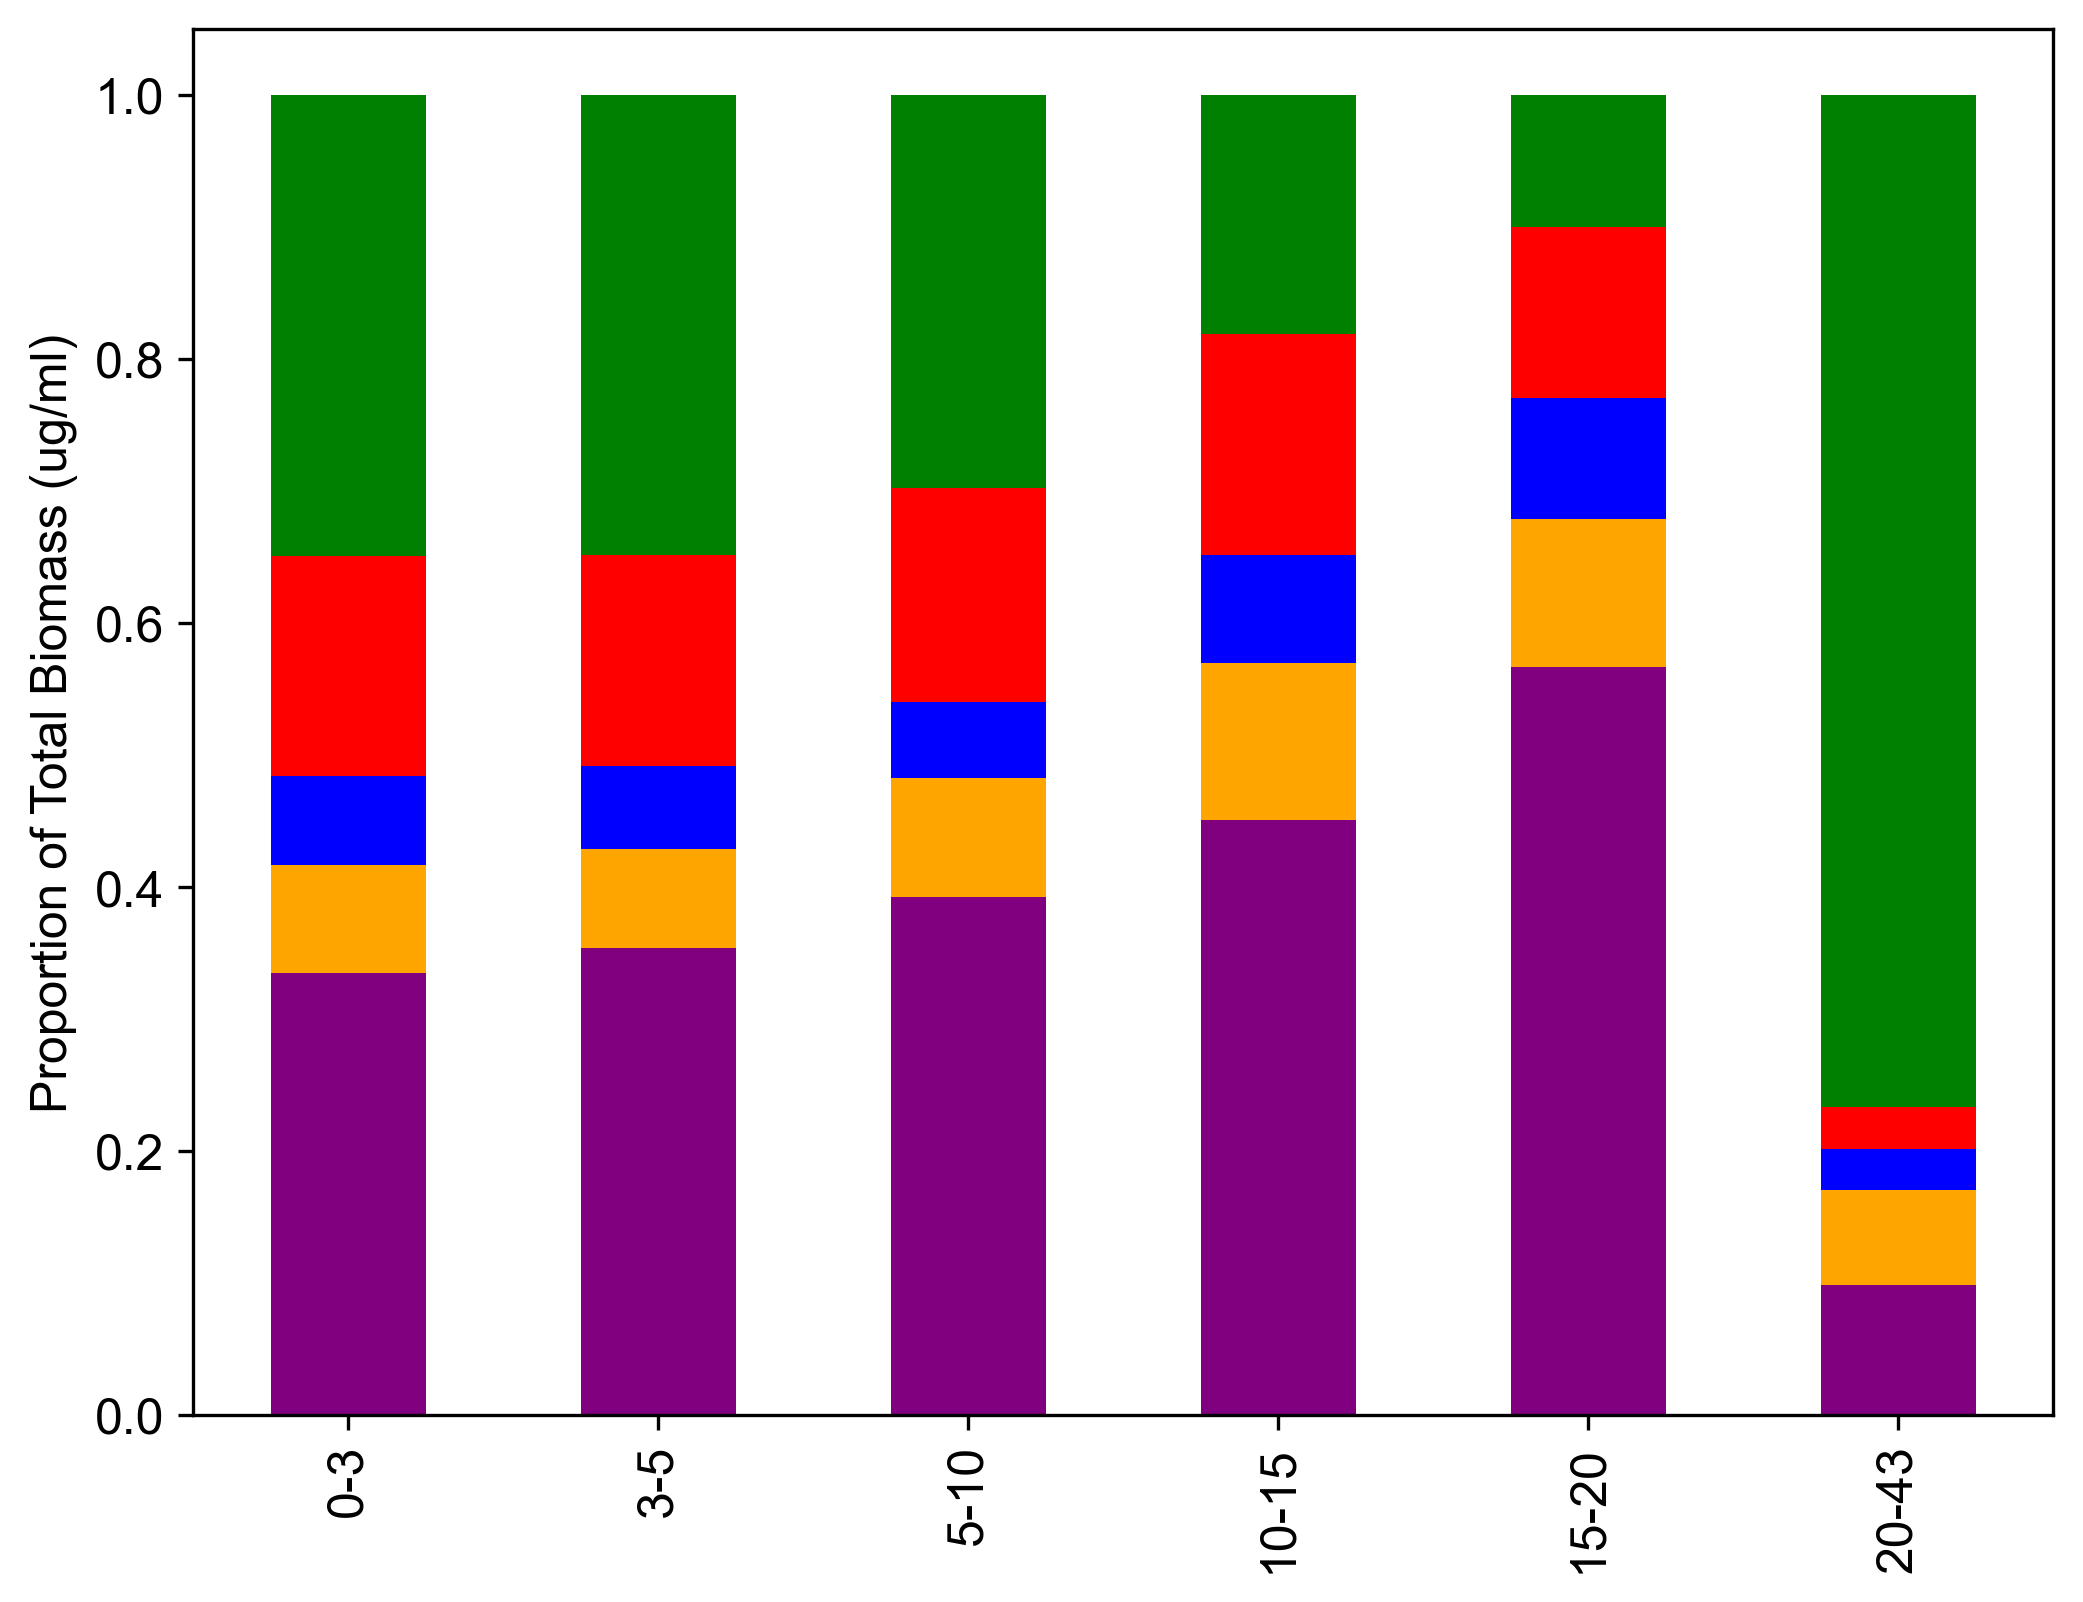

In [30]:
groups_biomass_by_column(merged_train, figure_titles, custom_palette, 'Depth')

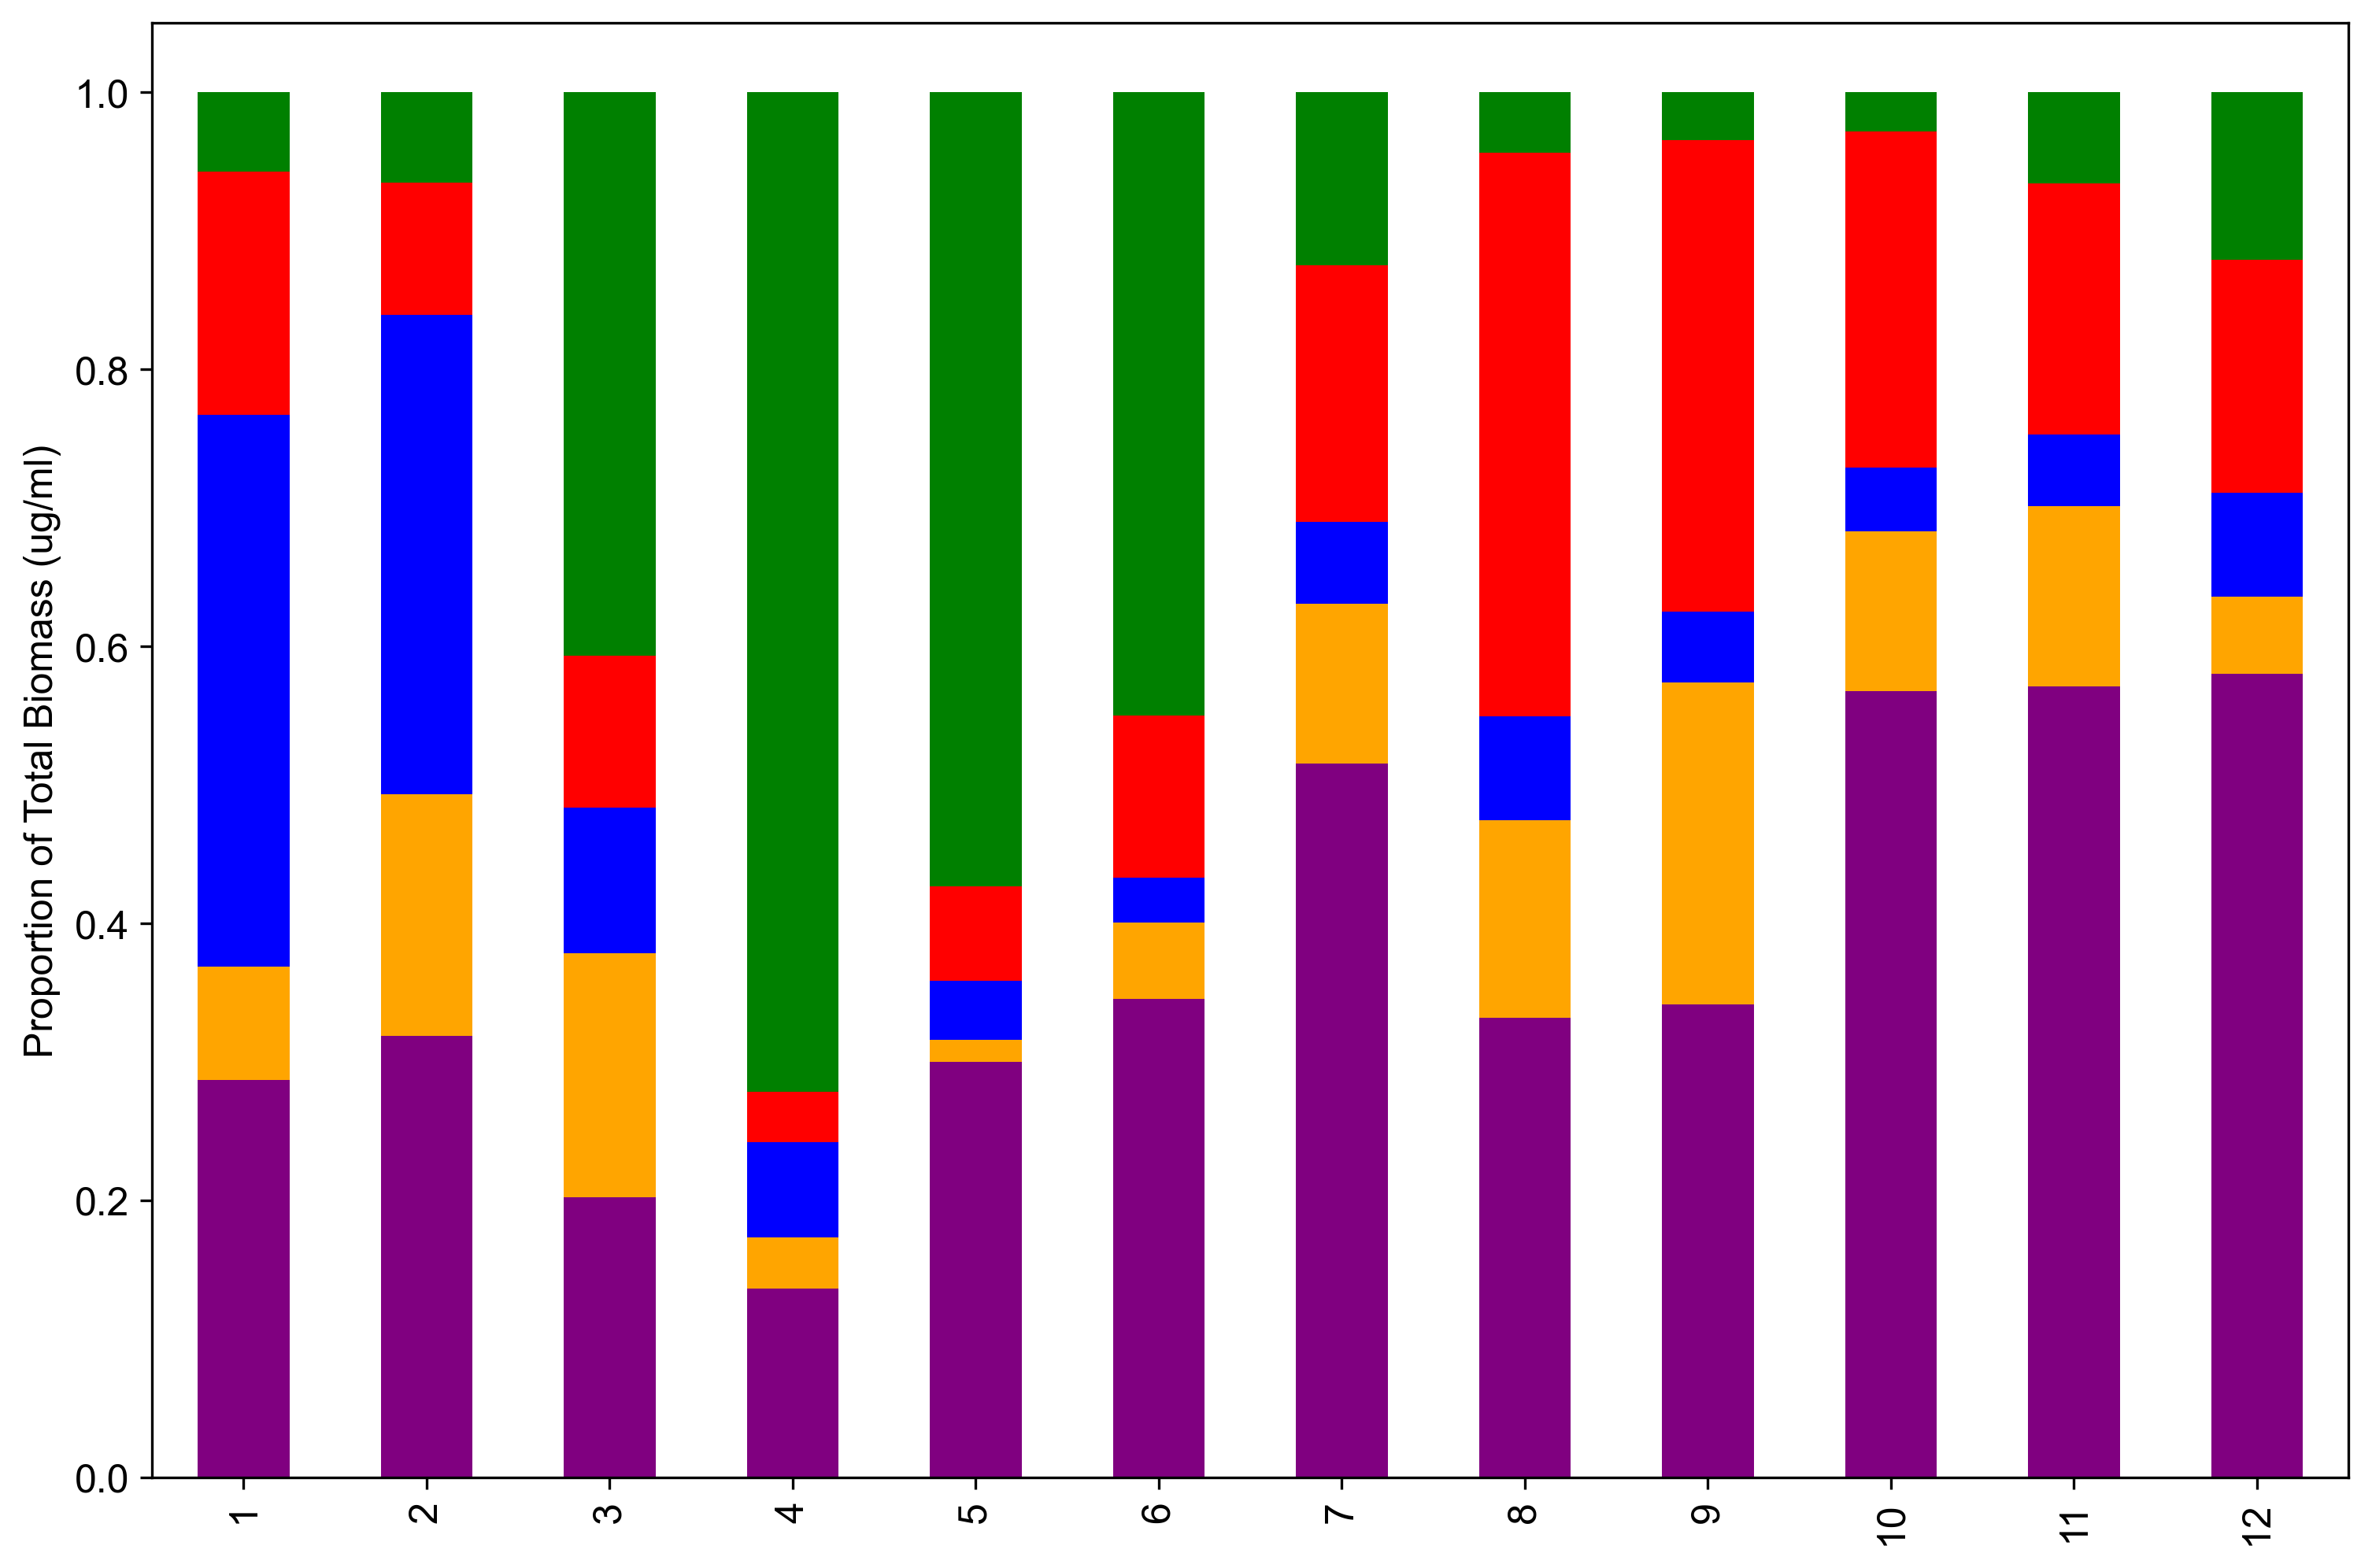

In [31]:
groups_biomass_by_column(merged_train, figure_titles, custom_palette, 'month')

In [32]:
# merged_train = merged_train.drop(['year', 'Depth', 'depth', 'week', 'month'], axis=1)
# orig_merged_train = orig_merged_train.drop(['year', 'Depth', 'depth', 'week', 'month'], axis=1)

# TODO: Check the addition of month
merged_train = merged_train.drop(['year', 'Depth', 'depth', 'week', 'yellow_sub'], axis=1)
orig_merged_train = orig_merged_train.drop(['year', 'Depth', 'depth', 'week', 'yellow_sub'], axis=1)

# Hyperparameter Grid Search for Model Training

We employed a hyperparameter grid search to fine-tune the performance of three different models: XGBoost (XGB), Support Vector Regression (SVR), and ElasticNet (ELF). The goal of this grid search was to optimize the models' hyperparameters in order to minimize the Mean Squared Error (MSE), a common measure used in regression tasks. To achieve this objective, we aimed to maximize the negative MSE, as a higher negative MSE corresponds to a lower real MSE.


## XGBoost (XGB)

XGBoost is a member of the gradient boosting family of algorithms. It combines multiple decision trees to create a robust ensemble model.

#### Strengths:
* Excellent predictive performance: XGBoost is known for its high accuracy and low generalization error.
* Robust to overfitting: Regularization techniques and tree pruning make XGBoost less prone to overfitting.
* Feature importance: XGBoost provides insights into the importance of each feature, aiding in feature selection.

#### Weaknesses:
* Requires careful hyperparameter tuning: Proper hyperparameter optimization is essential to maximize performance.
* Computationally intensive: Training XGBoost can be resource-intensive, particularly on large datasets.

#### Hyperparameters Explored:
We conducted a grid search over the following hyperparameters for the XGBoost model:

- `n_estimators`: This parameter represents the number of boosting rounds, which controls the number of decision trees in the ensemble.
- `max_depth`: It determines the maximum depth of each tree in the ensemble.
- `alpha`: The alpha parameter is related to L1 (Lasso) regularization, which helps prevent overfitting by adding a penalty for large coefficients.
- `lambda`: Lambda is the mixing parameter between L1 (Lasso) and L2 (Ridge) regularization. It balances the contribution of L1 and L2 regularization terms.

the XGBoost model aims to find the optimal values for these hyperparameters by minimizing the negative MSE, which is defined as:

$ \text{Negative MSE} = -\frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2 \$

Where:
- $N$ is the number of data points.
- $y_i$ represents the actual target value for the \(i\)-th data point.
- $\hat{y}_i$ is the predicted target value for the \(i\)-th data point using the XGBoost model.

## Support Vector Regression (SVR)

SVR is a member of the Support Vector Machine (SVM) family of algorithms, adapted for regression tasks. Its strengths include:

#### Strengths:
* Effective in high-dimensional spaces: SVR works well in cases with many features.
* Versatility: It can handle different kernel functions to capture complex relationships.
* Robust to outliers: SVR can be configured to be less sensitive to extreme values.

#### Weaknesses:
* Choice of kernel function: The performance of SVR heavily depends on selecting the appropriate kernel.
* Limited scalability: SVR may not be suitable for very large datasets or real-time applications.


#### Hyperparameters Explored:
For the SVR model, our grid search explored the following hyperparameters:

- `C`: This is the regularization parameter, which controls the trade-off between fitting the training data and preventing overfitting.
- `tol`: The tolerance for stopping criterion, which determines when to stop the training process.


## ElasticNet (ELF)

ElasticNet is a member of the linear regression family but combines L1 (Lasso) and L2 (Ridge) regularization. Its strengths include:

#### Strengths:
* Feature selection: ElasticNet can automatically perform feature selection by encouraging sparse coefficient vectors.
* Balance between Lasso and Ridge: It strikes a balance between the variable selection of Lasso and the stability of Ridge regression.

#### Weaknesses:
* Hyperparameter tuning: Selecting the optimal combination of L1 and L2 penalties can be challenging.
* Limited to linear relationships: ElasticNet is most effective when the relationship between features and the target variable is approximately linear.


### Hyperparameters Explored:
For the ElasticNet model, we explored the following hyperparameters in our grid search:

- `alpha`: This is the regularization parameter, which combines both L1 (Lasso) and L2 (Ridge) regularization.
- `l1_ratio`: The l1_ratio parameter determines the mixing ratio between L1 and L2 regularization terms.


<div style="height: 250px;"></div>

| Algorithm                               | Parameter               | Values                       |
|-----------------------------------------|-------------------------|------------------------------|
| **XGBoost (xgb)**                       | n_estimators     | 100, 300, 500                 |
|                                         | max_depth        | 2, 3, 5                      |
|                                         | alpha            | 0.01, 0.1, 1, 10             |
|                                         | lambda           | 0, 0.2, 0.8                  |
| **Support Vector Regression (svr)**     | C                | 0.001, 0.1, 1, 10, 100       |
|                                         | tol              | 1e-4, 1e-3, 1e-2             |
| **ElasticNet (elf)**                    | alpha            | 0.01, 0.1, 1, 10             |
|                                         | l1_ratio         | 0.2, 0.5, 0.8                |


In [33]:
pickled_params = 'best_grid_params.pkl'
do_search = not os.path.exists(pickled_params)

def two_scorer(mse=False):
    score = mean_squared_error if mse else r2_score
    return make_scorer(score, greater_is_better=mse==False)

In [34]:
if do_search:
    param_grid_per_model = {'xgb': {
        "model__n_estimators": [100, 300, 500], # Number of boosting rounds
        "model__max_depth": [2, 3, 5], # Maximum depth of a tree,
        "model__alpha": [0.01, 0.1, 1, 10], # L1 regularization term
        "model__lambda": [0, 0.2, 0.8], # Mixing parameter between L1 and L2 regularization
    },
    'svr':  {
        "model__C": [0.001, 0.1, 1, 10, 100], # Regularization parameter
        "model__tol": [1e-4, 1e-3, 1e-2] # Tolerance for stopping criterion
    },
    'elf': {
        "model__alpha": [0.01, 0.1, 1, 10], # Regularization parameter
        "model__l1_ratio": [0.2, 0.5, 0.8], # Mixing parameter between L1 and L2 regularization
    }}
    
    best_group_params_per_model = {}
    for model_name, param_grid in param_grid_per_model.items():
        best_group_params_per_model[model_name] = grid_search_cv(model_name, merged_train, param_grid=param_grid,
                                                                scoring_method=two_scorer(mse=True))
    
    with open(pickled_params, 'wb') as f:
        pickle.dump(best_group_params_per_model, f)
    
    best_group_params_per_model_fixed = {}
    for model_name, kwargs_per_group in best_group_params_per_model.items():
        best_group_params_per_model_fixed[model_name] = {}
        for group_num in kwargs_per_group.keys():
            best_group_params_per_model_fixed[model_name][group_num] = {}
            kwargs = kwargs_per_group[group_num]
            for param, val in kwargs.items():
                fixed_param = param.split('model__')[1]
                best_group_params_per_model_fixed[model_name][group_num][fixed_param] = val


    with open(pickled_params, 'wb') as f:
        pickle.dump(best_group_params_per_model_fixed, f)

else:
    with open(pickled_params, 'rb') as f:
        best_group_params_per_model_fixed = pickle.load(f)

In [35]:
regression_models = {}
for model_name, best_group_params_fixed in best_group_params_per_model_fixed.items():
    regression_models[model_name], _ = train(model_name, merged_train, group_kwargs=best_group_params_per_model_fixed, test_size=0.0,
                                             biomass_fn=np.log)
    

regression_models['lr'], _ = train('lr', merged_train, test_size=0.0, biomass_fn=np.log)

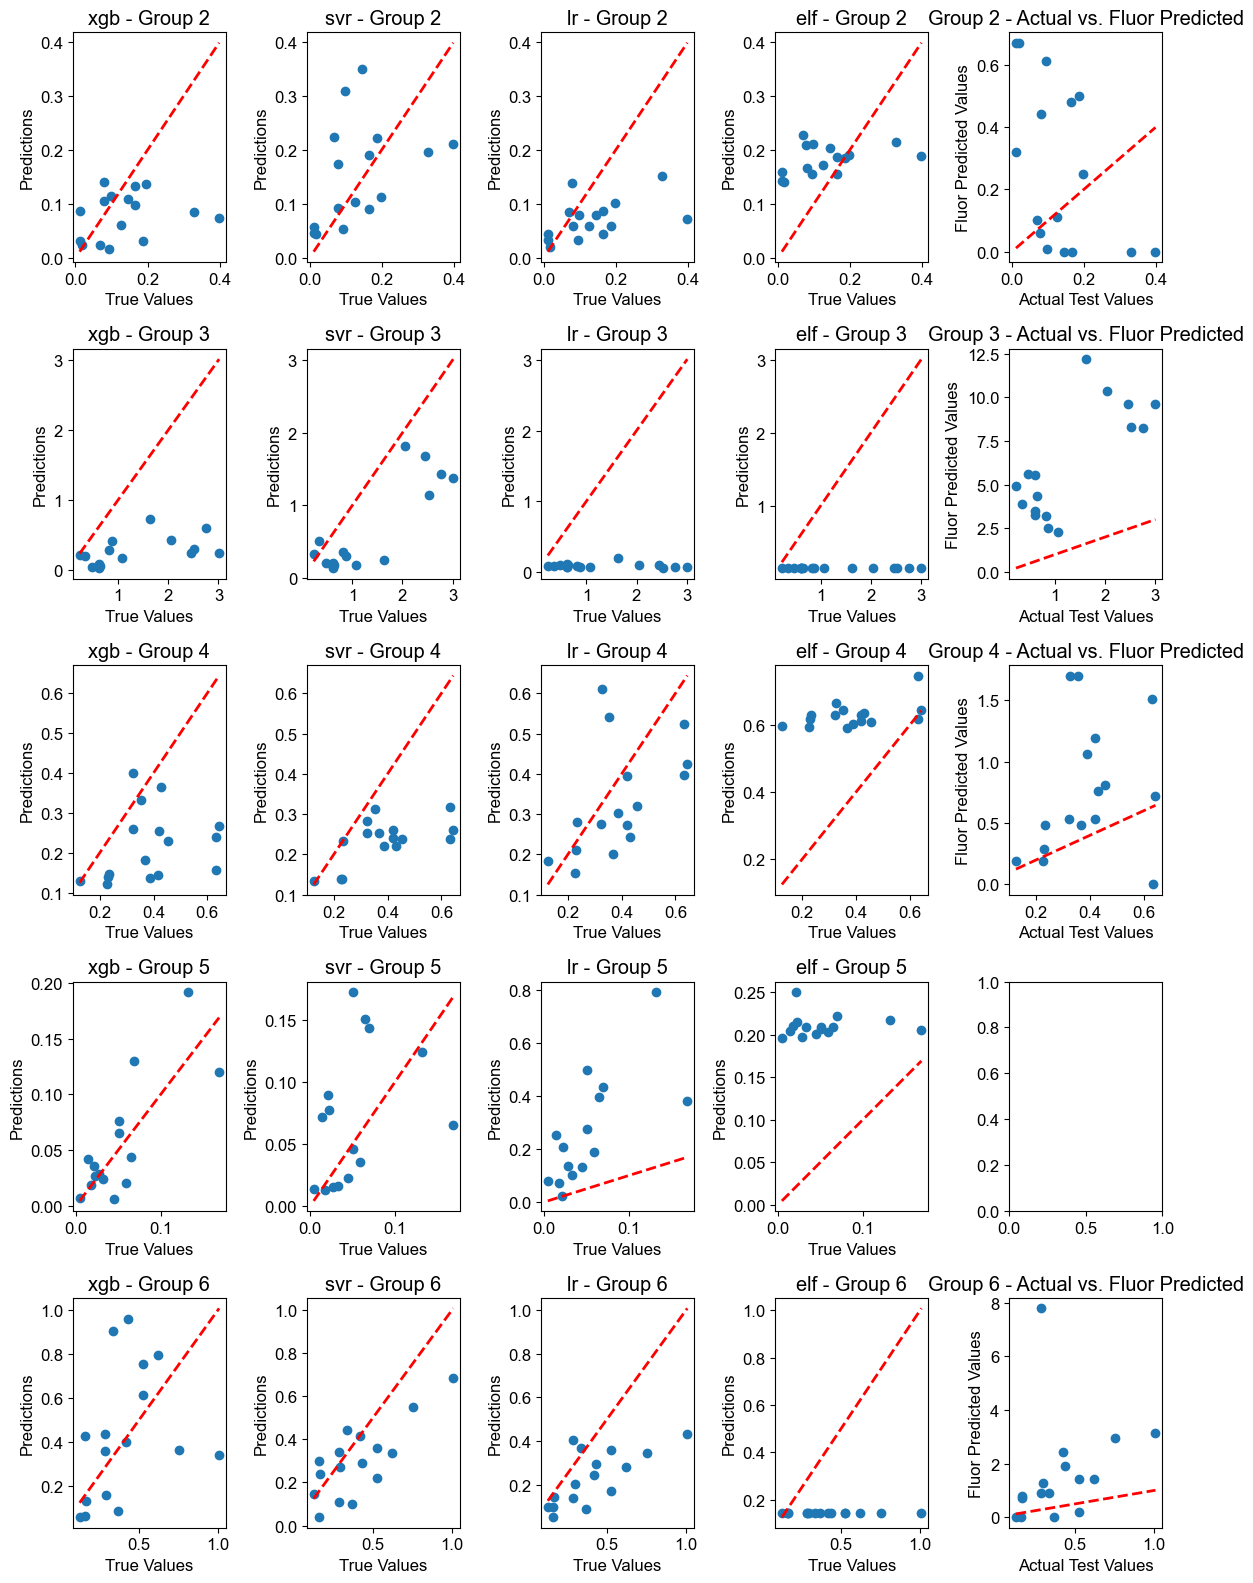

In [36]:
comparing_df = compare_all_models(regression_models, merged_val.drop(['year', 'Depth', 'week', 'yellow_sub'], axis=1), fluor_val_df, fluor_groups_map, predictions_fn=np.exp, model_names=['xgb', 'svr', 'lr', 'elf'])

In [37]:
Bluegreen_svr = regression_models['svr'][2].predict(merged_test[merged_train.columns].drop(['group_num', 'sum_biomass_ug_ml'], 1))
Diatmos_svr = regression_models['svr'][3].predict(merged_test[merged_train.columns].drop(['group_num', 'sum_biomass_ug_ml'], 1))
GreenAlgae_svr = regression_models['svr'][4].predict(merged_test[merged_train.columns].drop(['group_num', 'sum_biomass_ug_ml'], 1))
Cryptophyta_svr = regression_models['svr'][6].predict(merged_test[merged_train.columns].drop(['group_num', 'sum_biomass_ug_ml'], 1))

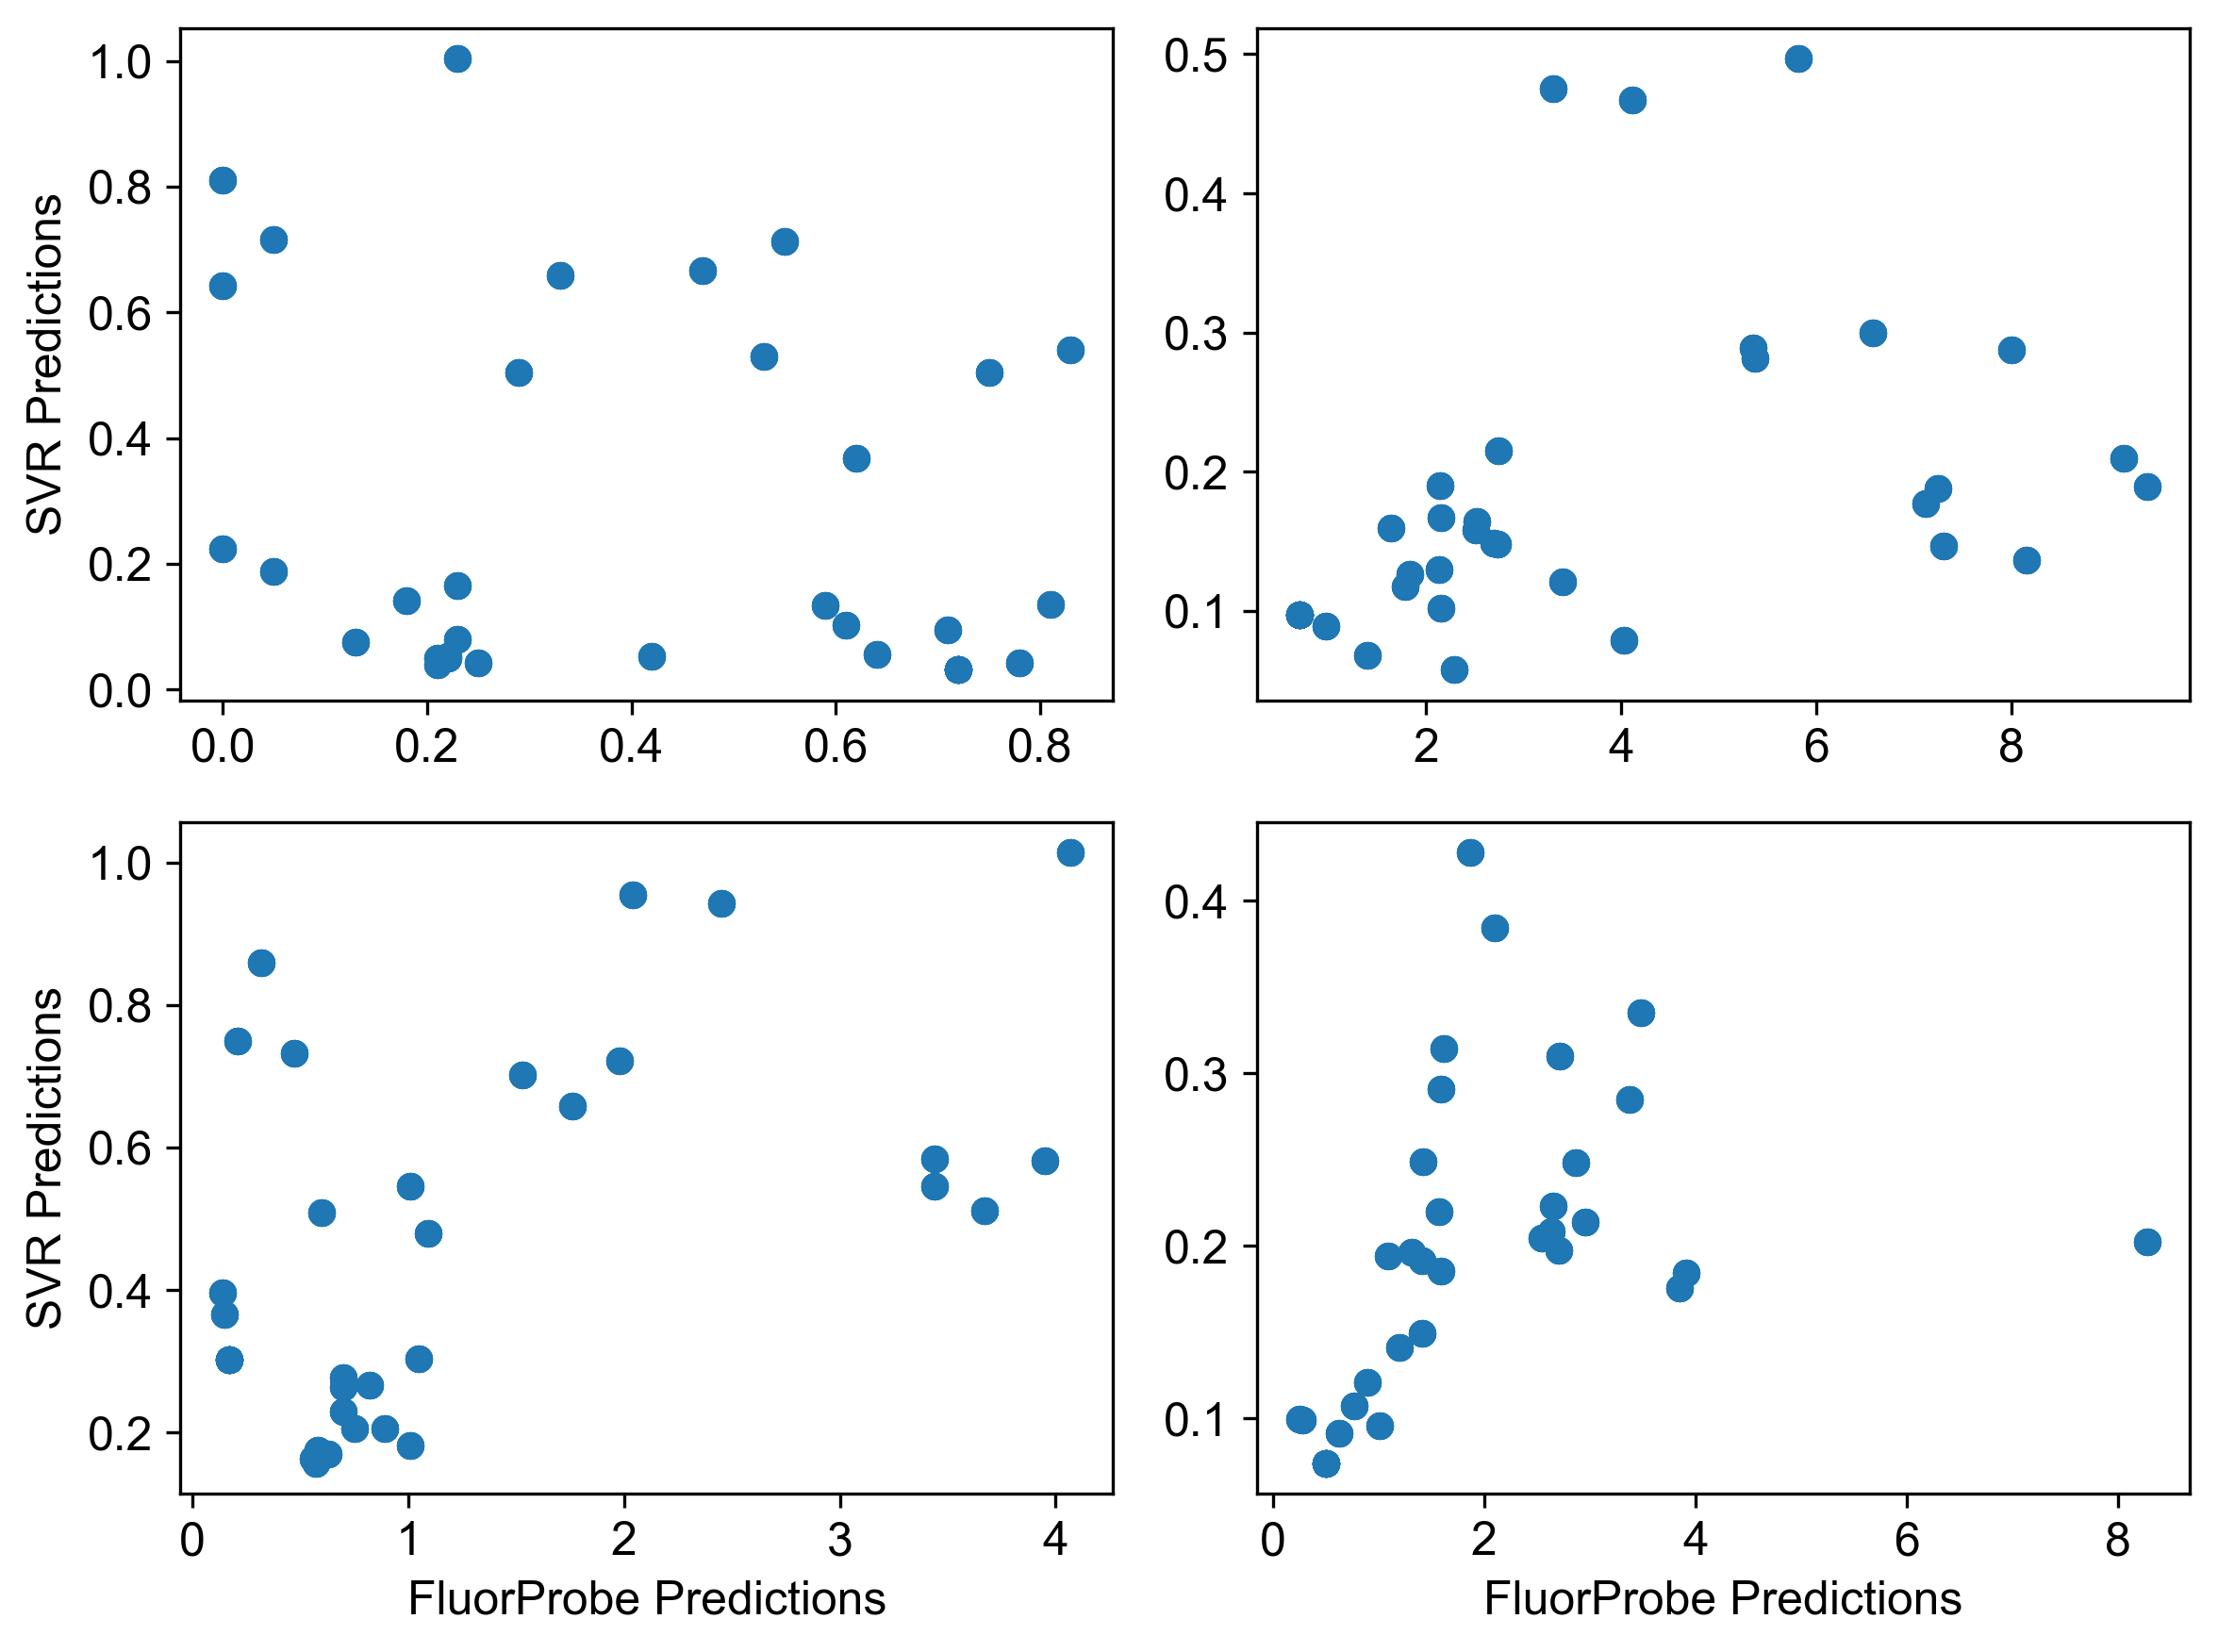

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6), dpi=300)

axes[0][0].scatter(fluor_test_df['Bluegreen'], np.exp(Bluegreen_svr))
# axes[0][0].set_title('Bluegreen')
axes[0][0].set_ylabel('SVR Predictions', fontsize=12)

axes[0][1].scatter(fluor_test_df['Diatoms'], np.exp(Diatmos_svr))
# axes[0][1].set_title('Diatoms')

axes[1][0].scatter(fluor_test_df['Green Algae'], np.exp(GreenAlgae_svr))
# axes[1][0].set_title('Green Algae')
axes[1][0].set_ylabel('SVR Predictions', fontsize=12)
axes[1][0].set_xlabel('FluorProbe Predictions', fontsize=12)

axes[1][1].scatter(fluor_test_df['Cryptophyta'], np.exp(Cryptophyta_svr))
# axes[1][1].set_title('Cryptophyta')
axes[1][1].set_xlabel('FluorProbe Predictions', fontsize=12)


plt.tight_layout()
plt.show()

Top left - BlueGreen
Top right - Diatoms
Bottom left - Green algae
Bottom right - cryptophyta

In [54]:
cleaned_res = compare_by_mpe(merged_test, regression_models, predict_cols=merged_train.drop(['sum_biomass_ug_ml', 'group_num'], axis=1).columns, predict_fn=np.exp)

In [55]:
fp_res = calc_mpe_fp(fluor_test_df, with_group_5=False)

# Results and Evaluations

### Framework for Comparing Fluor-Probe's Predictions  with Real Phytoplankton Biomass

#### Step 1: Aggregation of Real Biomass Data

For each unique combination of 'week,' 'year,' 'month,' and 'depth,' we calculate the total biomass by summing the biomasses of all the different phytoplankton groups within that combination. 

Let $B_{i}$ represent the biomass of group $i$ within a specific combination, and $B_{total}$ be the total biomass within that combination. The percentage of biomass for group $i$: $b_{i}$, is calculated as:

$\text{Percentage Biomass for Group } i = b_{i} = \frac{B_{i}}{B_{\text{total}}} \times 100$

#### Step 2: Regression Model

We employ a regression model to predict the biomass of each phytoplankton group based on the given attributes ('week,' 'year,' 'month,' and 'depth').

#### Step 3: Aggregation of Predicted Biomass Data

For each unique combination of 'week,' 'year,' 'month,' and 'depth,' we calculate the total predicted biomass by summing the predicted biomasses of all the different phytoplankton groups within that combination. 

Let $P_{i}$ represent the predicted biomass of group $i$ within a specific combination, and $P_{\text{total}}$ be the total predicted biomass within that combination. The percentage of predicted biomass for group $i$: p_{i}, is calculated as:


$\text{Percentage Predicted Biomass for Group } i = p_{i} = \frac{P_{i}}{P_{\text{total}}} \times 100$

<div style="height: 200px;"></div>

#### Step 4: Calculation of Mean Proportion Error (MPE)

The Mean Proportion Error (MPE) for each phytoplankton group is calculated as the average difference between the real percentage biomass and the predicted percentage biomass across all combinations of 'week,' 'year,' 'month,' and 'depth':

$
\text{MPE for Group } i = \frac{1}{N} \sum_{j=1}^{N} \left| b_{i} - p_{i}\right|
$

Where:
- $N$ is the total number of unique combinations of 'week,' 'year,' 'month,' and 'depth' in the dataset.
- The absolute difference between the real and predicted percentages is used to account for both overestimations and underestimations.

For the total MPE we can sum $\forall{i} \ \ MPE_{i}$ and divide by the  number of groups, $n$:

$\text{Total MPE} = \frac{1}{n} \sum_{j=1}^{n} \left| MPE_{i}\right|$

#### MPE per model per group
Blue are the results for XGB, orange are for SVR, green are for ELF, and red are the original FP.

In [56]:
all_results = pd.concat([fp_res, cleaned_res]).reset_index(drop=True)
all_results

,Model,2,3,4,6,5
0,FP,15.760983,37.262523,37.129190,14.146413,NaN
1,xgb,7.837613,16.973140,13.927954,10.207693,10.442432
2,svr,9.318584,7.608017,13.405229,7.096669,7.854625
3,elf,7.816379,6.848017,14.167923,10.369703,9.376711
4,lr,7.990125,7.606935,13.085114,7.836597,13.702181


In [63]:
def bar_plot_all_models_cleaned_no_smogn(df):
    # Filter the DataFrame to include only the desired columns and models
    selected_columns = [2, 3, 4, 5, 6]
    selected_models = ['xgb', 'svr', 'elf', 'FP']
    selected_sources = ['FP', 'Cleaned']
    filtered_df = df[df['Model'].isin(selected_models)]

    # Set up the figure and axis for plotting
    fig, ax = plt.subplots(figsize=(5, 4), dpi=300)
    plt.xticks(rotation=90)
    
    # Width of each bar
    bar_width = 0.15
    index = np.arange(len(selected_columns))

    # Iterate through each model and create a grouped bar plot
    for i, model in enumerate(selected_models):
        model_data = filtered_df[filtered_df['Model'] == model]
        y = model_data[selected_columns].values[0]  # Corresponding values for the model
        ax.bar(index + i * bar_width, y, bar_width, label=model)

    # Set labels and title
#     ax.set_xlabel('Taxonomic Groups', fontsize=12)
    ax.set_ylabel('Mean Percentage Error (%)', fontsize=12)
#     ax.set_title('Comparison of MPE for Different Models')
    ax.set_xticks(index + bar_width * (len(selected_models) - 1) / 2)
    ax.set_xticklabels(figure_titles[str(x)] for x in selected_columns)
#     ax.legend()
    
    # Show the plot
    plt.show()

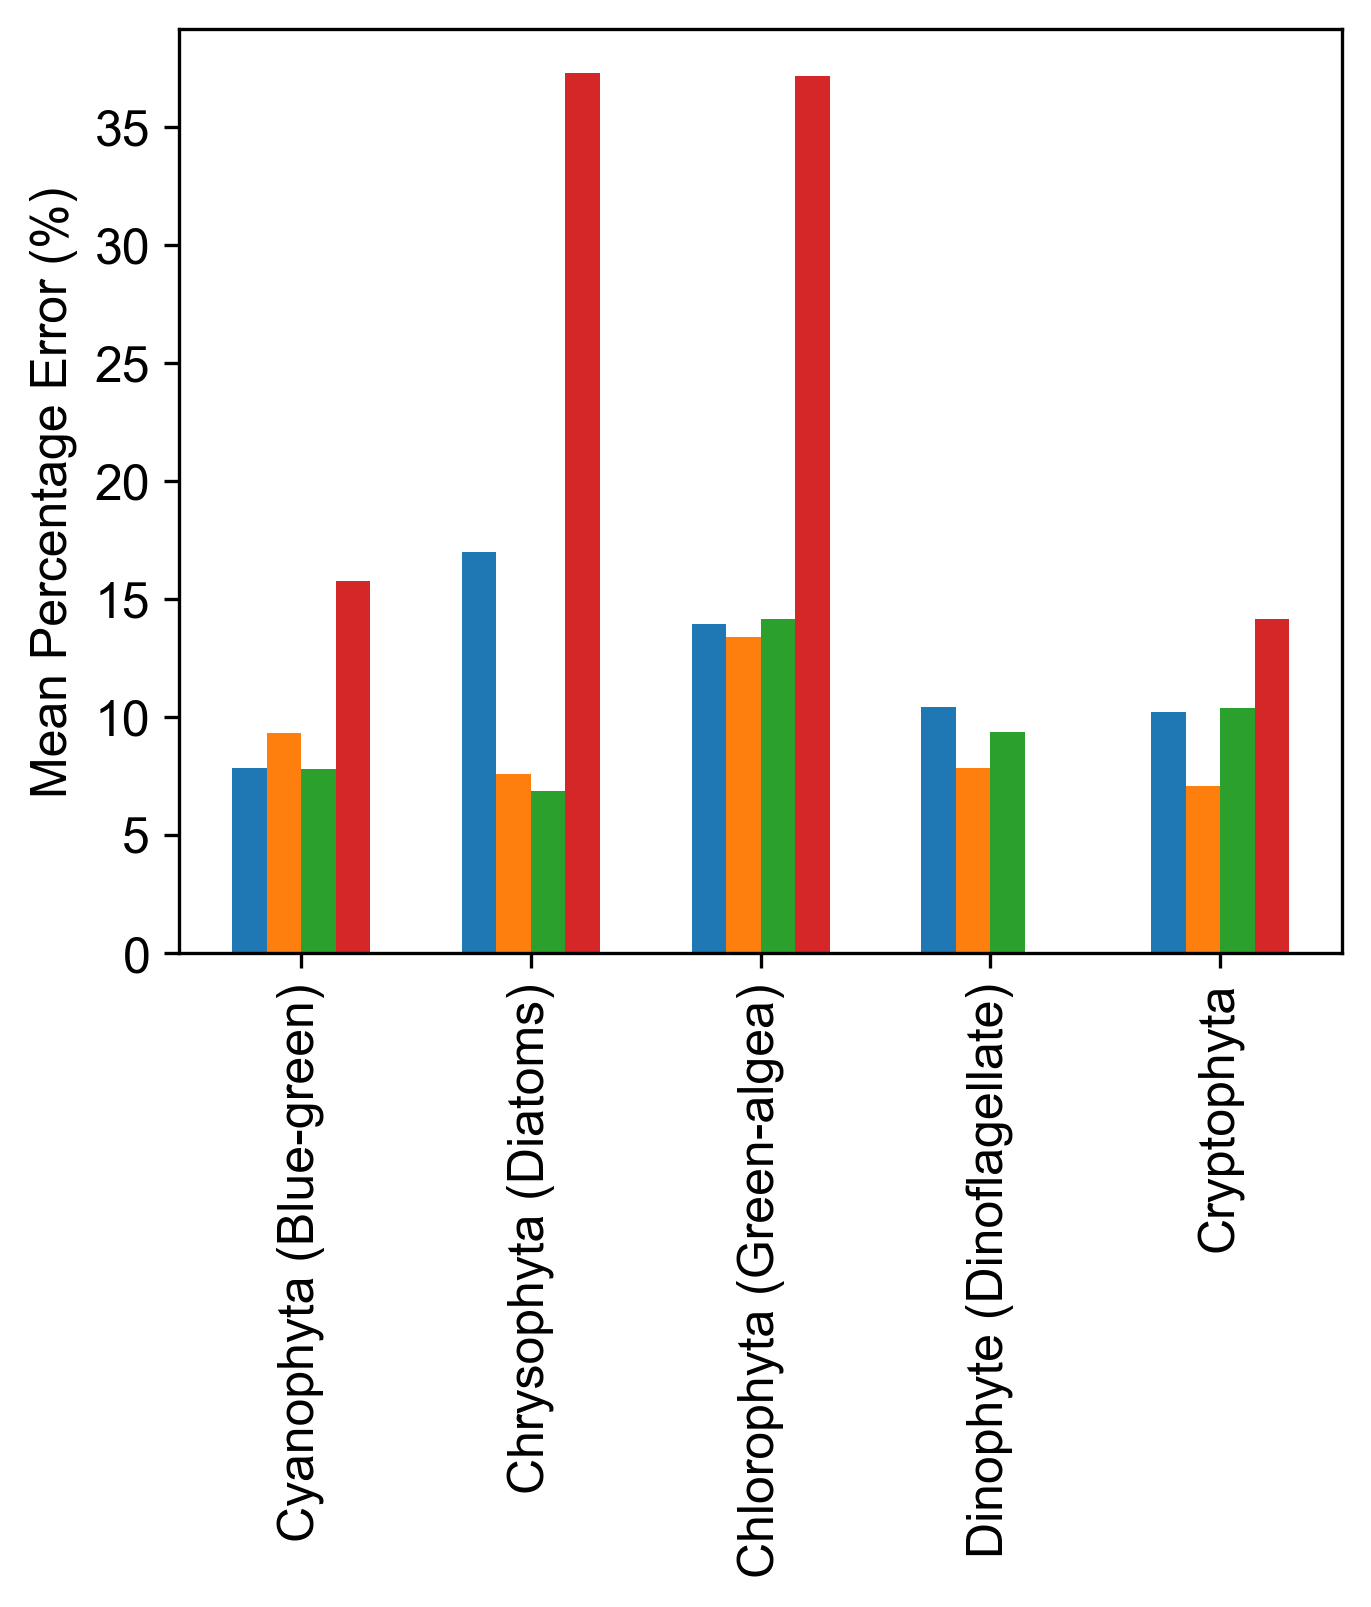

In [64]:
bar_plot_all_models_cleaned_no_smogn(all_results)

Blue for XGB, orange for SVR, green for ELF, red for FP.

In [89]:
# shap_values_list_xgboost = plot_shap_values(merged_train, regression_models_custom_smogn['xgb'], merged_val.drop(['Depth', 'week', 'year', 'yellow_sub'], axis=1))

In [90]:
# shap_values_list_svr = plot_shap_values(merged_train, regression_models_custom_smogn['svr'], merged_val.drop(['Depth', 'week', 'year', 'yellow_sub'], axis=1), do_sample=True)

In [91]:
# with open('data/shap_values_list_xgboost.pkl', 'wb') as f:
#     pickle.dump(shap_values_list_xgboost, f)
    
# with open('data/shap_values_list_svr_clean.pkl', 'wb') as f:
#     pickle.dump(shap_values_list_svr, f)

In [92]:
with open('data/shap_values_list_xgboost.pkl', 'rb') as f:
    shap_values_list_xgboost = pickle.load(f)
    
with open('data/shap_values_list_svr_clean.pkl', 'rb') as f:
    shap_values_list_svr = pickle.load(f)

In [93]:
def shap_heatmap(shap_values_by_group, do_abs=True, model='SVR'):
    features_list = merged_val.drop(['group_num', 'sum_biomass_ug_ml', 'week', 'year', 'Depth', 'yellow_sub'], axis=1).columns.tolist()

    # Create a DataFrame from the Shapley values
    shap_df = pd.DataFrame({k: np.average(np.abs(v.values) if do_abs else v.values, axis=0)
                            for k, v in shap_values_by_group.items()}, index=features_list)

    scaler = MinMaxScaler()
    scaled_shap_df = pd.DataFrame(scaler.fit_transform(shap_df), columns=shap_df.columns, index=shap_df.index).sort_index(axis=1)
    scaled_shap_df.rename(columns={x: figure_titles[str(x)] for x in scaled_shap_df.columns}, inplace=True)
    scaled_shap_df = scaled_shap_df.transpose().rename(columns={x: figure_titles[str(x)] for x in scaled_shap_df.transpose().columns})
    scaled_shap_df = scaled_shap_df.reindex(sorted(scaled_shap_df.columns), axis=1)

    # Plot the heatmap
    plt.figure(figsize=(5, 4), dpi=300)
    heatmap = sns.heatmap(scaled_shap_df, cmap='coolwarm', annot=True, fmt=".1f")
    
#     plt.title(f"Shapley Values Heatmap - {model}")
#     plt.xlabel("Features", fontsize=12)
    plt.ylabel("Taxonomic Groups", fontsize=12)
#     plt.yticks(rotation=90)
    plt.show()


In [94]:
_ = shap_values_list_svr.pop(9)
_ = shap_values_list_svr.pop(7)

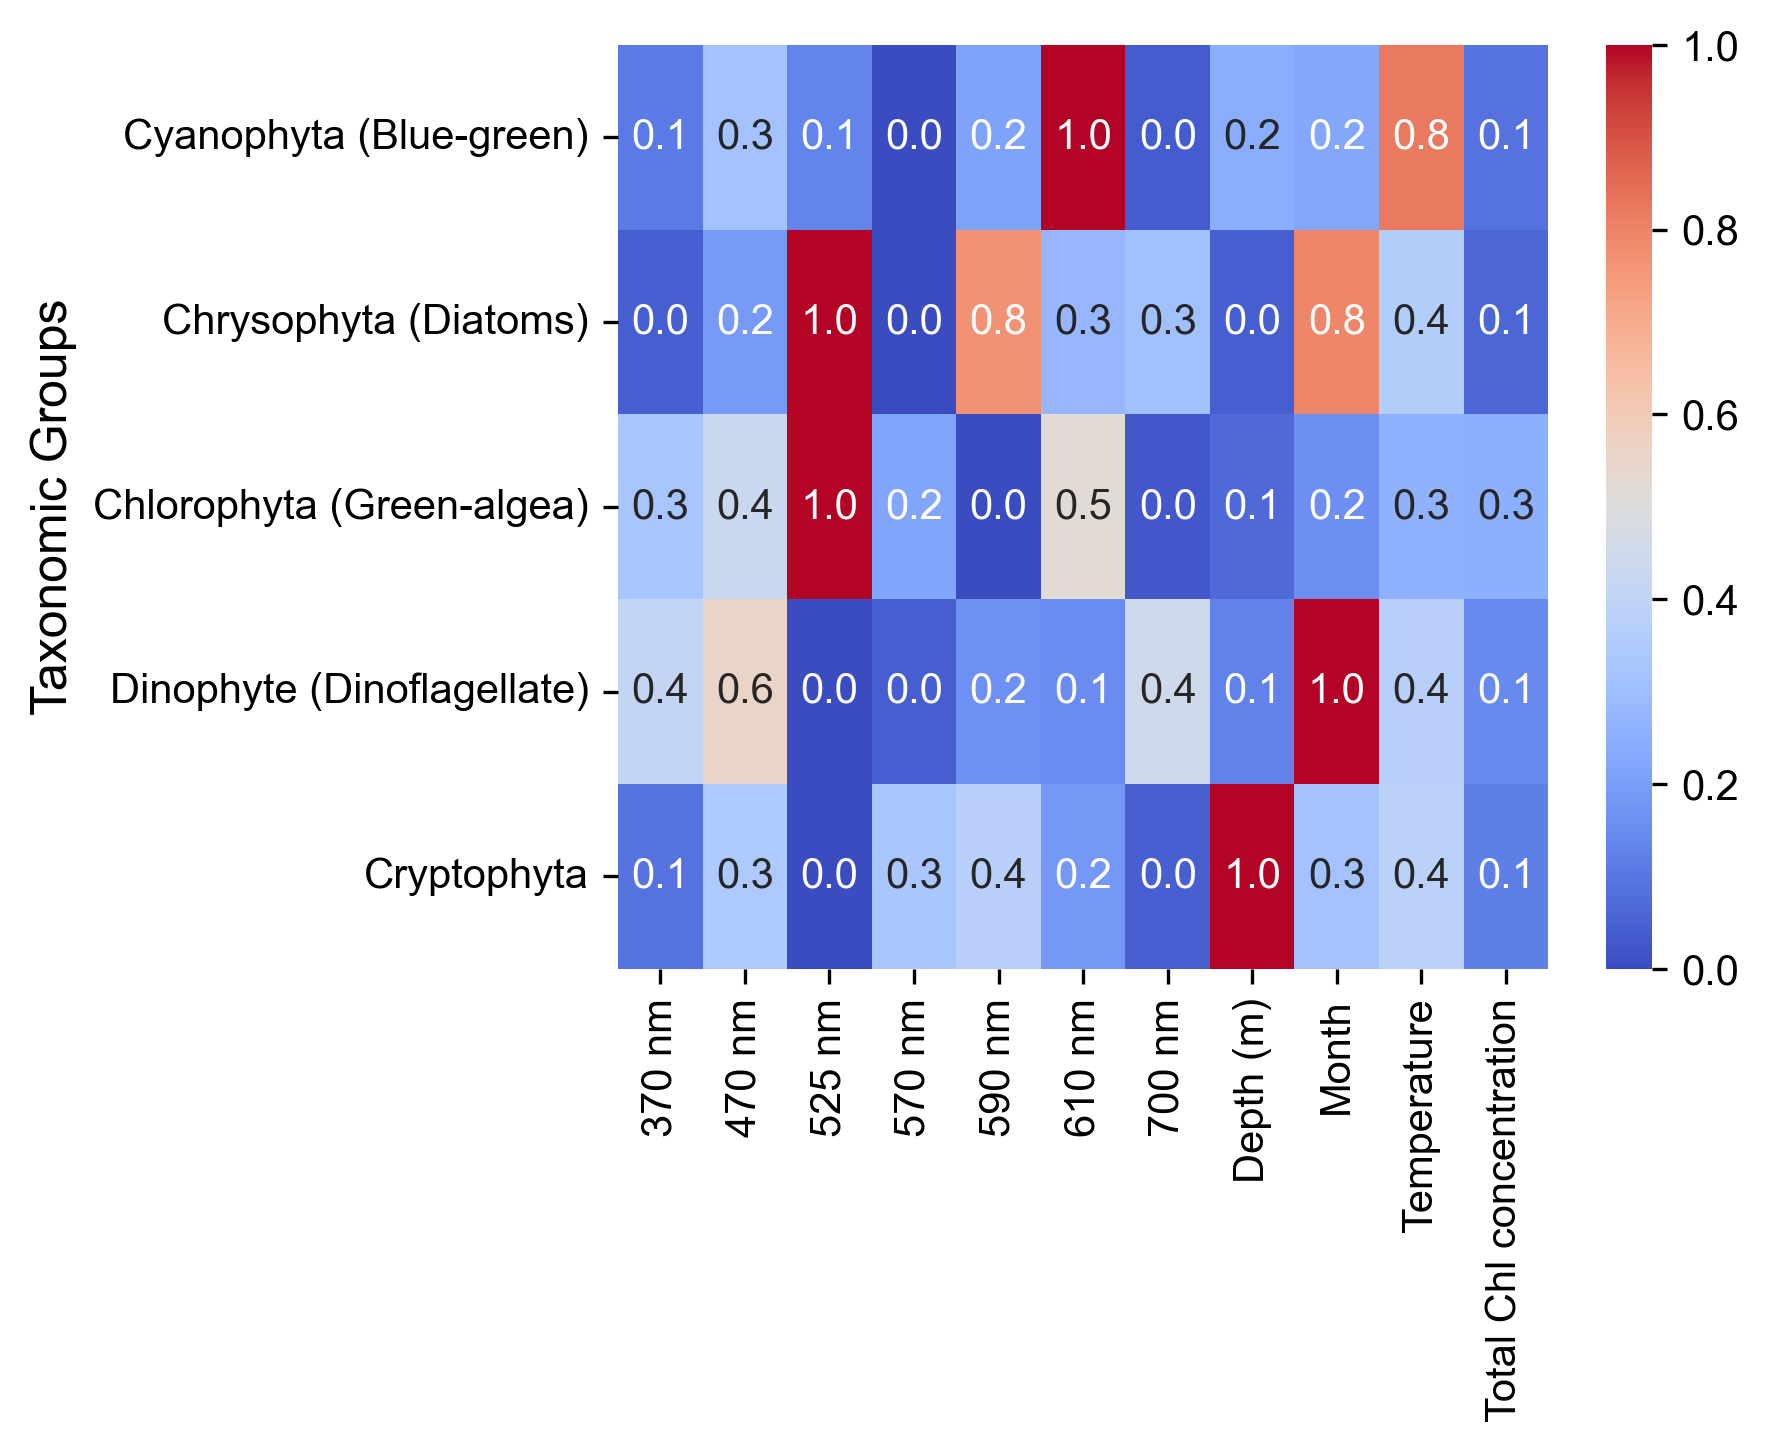

In [95]:
shap_heatmap(shap_values_list_svr, do_abs=True)